# Problem Statement:

### How reliably can the words in a subreddit posts predict whether the post was intended for a 'good advice' or 'bad advice' subreddit?

# Imports

In [122]:
import pandas as pd
import numpy as np
import requests
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import regex as re
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# API & JSON:

In [2]:
def generate_json_posts(subreddit_str, size):
    
    # Setup URL of API
    base_url = "https://api.pushshift.io/reddit/search/submission"    
    
    # Create the params of the API URL
    params = {
        "subreddit": subreddit_str,
        "size": size
    }

    # Response
    res = requests.get(base_url, params)
    res_check = res.status_code
    
    # Check response is good
    if (res_check >= 200 and res_check < 300):
        
        # Create JSON:
        data = res.json()
        posts = data["data"]
        
        return posts
    else:
        return f"Check HTTP Error: {res_check}"

In [3]:
lpt_posts = generate_json_posts("LifeProTips", 1000)
ulpt_posts = generate_json_posts("UnethicalLifeProTips", 1000)

### Save JSON Files:

In [4]:
pd.to_pickle(lpt_posts, "../datasets/lpt_posts_json")
pd.to_pickle(ulpt_posts, "../datasets/ulpt_posts_json")

### Read JSON Files:

In [2]:
lpt_posts = pd.read_pickle("../datasets/lpt_posts_json")
ulpt_posts = pd.read_pickle("../datasets/ulpt_posts_json")

# Dataframe

## Create DF

In [3]:
# # Create DF
# lpt_df = pd.DataFrame(lpt_posts)
# ulpt_df = pd.DataFrame(ulpt_posts)

In [4]:
# df = lpt_df.append(ulpt_df, ignore_index=True)

In [61]:
# Read In Existing:
df = pd.read_pickle("../datasets/df_model_1.2")

In [62]:
df.shape

(2000, 70)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 70 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   all_awardings                  2000 non-null   object 
 1   allow_live_comments            2000 non-null   bool   
 2   author                         2000 non-null   object 
 3   author_flair_css_class         0 non-null      object 
 4   author_flair_richtext          1788 non-null   object 
 5   author_flair_text              0 non-null      object 
 6   author_flair_type              1788 non-null   object 
 7   author_fullname                1788 non-null   object 
 8   author_patreon_flair           1788 non-null   object 
 9   author_premium                 1788 non-null   object 
 10  awarders                       2000 non-null   object 
 11  can_mod_post                   2000 non-null   bool   
 12  contest_mode                   2000 non-null   b

In [7]:
df["selftext"].head()

0    I stream video games on Twitch, and got into t...
1                                            [removed]
2                                            [deleted]
3    If you turn the can upside down and spray them...
4                                                     
Name: selftext, dtype: object

## Exploration

- Investigate additional features: `score`, `author`, `over_18`

    - `author` 
         - Set cvec hyparam 'lowercase' == False
         - Has a number of `[deleted]` author names

- Notes for next model:
    - `created_utc` & `retrieved_on` as features

In [9]:
# Column names
df.columns

Index(['all_awardings', 'allow_live_comments', 'author',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_type', 'author_fullname', 'author_patreon_flair',
       'author_premium', 'awarders', 'can_mod_post', 'contest_mode',
       'created_utc', 'domain', 'full_link', 'gildings', 'id',
       'is_crosspostable', 'is_meta', 'is_original_content',
       'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video',
       'link_flair_background_color', 'link_flair_css_class',
       'link_flair_richtext', 'link_flair_template_id', 'link_flair_text',
       'link_flair_text_color', 'link_flair_type', 'locked', 'media_only',
       'no_follow', 'num_comments', 'num_crossposts', 'over_18',
       'parent_whitelist_status', 'permalink', 'pinned', 'pwls',
       'retrieved_on', 'score', 'selftext', 'send_replies', 'spoiler',
       'stickied', 'subreddit', 'subreddit_id', 'subreddit_subscribers',
       'subreddit_type', 'suggested_

# Feature Engineering & Preprocessing

### Cleaning:

- **HTML Artifacts:**
- **Non-Letters**
- **Stopwords**
- **Lemmatize words**

**Lemmatize:**

- This can help with some typos in our word analysis.
    - For example, we can use lemmatization to identify `untill`, and make a necessary adjustment to model input
- Lemmatization will not be applied to `author`, as these are the usernames attached to the post submission to the subreddit.

In [8]:
tokenizer = RegexpTokenizer(r'\w+')
lemma = WordNetLemmatizer()
def to_lemma(data, col):
    for i in range(len(data[col])):
        data[col][i] = tokenizer.tokenize(data[col][i])
        for j in data[col][i]:
            data[col][i] = [lemma.lemmatize(j) for j in data[col][i]]
    data[col] = data[col].apply(lambda i: " ".join(i))
    return data

### Define Stopwords
- In this iteration of the model, the `LPT` or `lpt` word will be removed from the `title` and `selftext` as a stopword.

In [9]:
stopset = set(nltk.corpus.stopwords.words("english"))
stopset.add("lpt")
stopset.add("lptrequest")

stopset.add("ulpt")
stopset.add("ulptrequest")

## Function to perform each Preprocessing task:

- The idea behind this function is to have a function to call on a given feeature that should have all of the preprocessing tasks performed, as listed above.
    - Otherwise, each of the above functions can be called on a feature as needed.

In [10]:
def clean_df(data, col):

    # Remove non-letters:
    new_lst = []
    for i in data[col]:
        soup = BeautifulSoup(i, "lxml")
        new_lst.append(re.sub("[^a-zA-Z]", " ", soup.get_text()))
    data[col] = new_lst
    # Reference to: https://www.reddit.com/r/learnpython/comments/an62wx/how_to_remove_html_from_pandas_dataframe_without/
    
    
    # Make lowercase:
    data[col] = data[col].str.lower()
    

    # Lemmatize:
    for i in range(len(data[col])):
        data[col][i] = tokenizer.tokenize(data[col][i])
        for j in data[col][i]:
            data[col][i] = [lemma.lemmatize(j) for j in data[col][i]]
    data[col] = data[col].apply(lambda i: " ".join(i))
    

    # Remove Stopwords:
    data[col] = [" ".join([i for i in x.split()
                           if i not in stopset])
                           for x in data[col]]
    
    return data

In [11]:
clean_df(df, "title");

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/bs4/__init__.py:389: UserWarning: "https://www.reddit.com/r/vancouver/comments/g540z0/when_you_see_guide_dogs_make_way_for_them_and/?utm_source=share&amp;utm_medium=ios_app&amp;utm_name=iossmf" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [12]:
df.shape

(2000, 70)

### Binarize target `y` variable

In [13]:
df["subreddit"].value_counts()

UnethicalLifeProTips    1000
LifeProTips             1000
Name: subreddit, dtype: int64

In [14]:
# Create numeric values for y var to be passed into model

df["subreddit"] = df["subreddit"].map({"LifeProTips": 1,
                                       "UnethicalLifeProTips": 0
                                      })

In [15]:
df["subreddit"].value_counts()

1    1000
0    1000
Name: subreddit, dtype: int64

### Save Dataframe:

In [37]:
pd.to_pickle(df, "../datasets/df_model_1.2")

# Features Set

- Mode word: `videochat`, used 3406 times across all posts

In [63]:
features = df["title"]

In [64]:
X = features
y = df["subreddit"]

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.33,
                                                    random_state=42)

In [66]:
X_train.head()

81      financial situation secure please consider don...
915     want read unbiased major news story regarding ...
1018                   request dealing loud rude neighbor
380     refill empty dish soap bottle dog shampoo easi...
1029              request college exam school make easier
Name: title, dtype: object

### The CountVectorizer DF

In [67]:
cvec_check = CountVectorizer()
cvec_check.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [68]:
X_train = cvec_check.transform(X_train)

In [69]:
X_train_df = pd.DataFrame(X_train.toarray(),
                          columns=cvec_check.get_feature_names())

In [70]:
X_train_df.head()

,abandoned,ability,able,absentee,absolutely,abundance,abusing,ac,academic,accepts,...,younger,youtube,yr,yummy,zaxbys,zero,zip,zipcar,zoom,zoombombed
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
X_train_df["youtube"].value_counts()  # Youtube appears in ULPT 1334 times. 6 times in LPT

0    1334
1       6
Name: youtube, dtype: int64

In [27]:
word_rates = cvec_check.vocabulary_

In [72]:
def get_mode_word(dct):
    for k, v in dct.items():
        highest_k =""
        highest_v = 0
        if v > highest_v:
            highest_v = v
            highest_k = k
    return f"Highest frequency word: {highest_k}, {highest_v} appearances"

In [73]:
get_mode_word(word_rates)

'Highest frequency word: videochat, 3406 appearances'

# Models

### Baseline Score & Reset Train/Test Split

In [123]:
# Read In Existing:
df = pd.read_pickle("../datasets/df_model_1.2")

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.33,
                                                    random_state=42)

**Baseline Accuracy**

In [125]:
y_test.value_counts(normalize=True)

0    0.507576
1    0.492424
Name: subreddit, dtype: float64

## Logistic Regression w/ CountVectorizer

In [76]:
logreg_pipe = Pipeline([
    ("cvec", CountVectorizer()),
    ("logreg", LogisticRegression())
])

**Looking at an untweaked model:**

In [34]:
# Testing the model performance on new data
print(f"CV Score Mean: {cross_val_score(logreg_pipe, X_train, y_train, cv=5).mean()}")

# Fit
logreg_pipe.fit(X_train, y_train)

# Train Score
print(f"Train Score: {logreg_pipe.score(X_train, y_train)}")

# Test Score
print(f"Test Score: {logreg_pipe.score(X_test, y_test)}")
logreg_default_score = logreg_pipe.score(X_test, y_test)

CV Score Mean: 0.7843283582089553
Train Score: 0.9843283582089553
Test Score: 0.7924242424242425


### Tuning:

In [37]:
logreg_params = {
    "cvec__ngram_range": [(1, 1), (1, 2)],     
    "cvec__max_features": [2500, 5000],  
    "cvec__min_df": [1, 2, 5, 10],  
    "logreg__penalty": ["l1", "l2"],
    "logreg__C": [1, 5, 10],
    "logreg__random_state": [42],  # Needs a random_state when using the solvers below
    "logreg__solver": ["saga", "liblinear"],  # Will adjust to "lbfgs" if model prefers "l2" penalty
#     "logreg__max_iter": [100, 250, 500],  # This is being taken out, too many models
    "logreg__verbose": [1]  # Needs any positive int when using 'liblinear' solver
}

logreg_gs = GridSearchCV(logreg_pipe,
                         logreg_params,
                         cv=5,
                         verbose=10)

# Model 1: 

In [38]:
logreg_gs.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.724, total=   0.2s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.746, total=   0.2s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.731, total=   0.4s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.720, total=   0.2s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.769, total=   0.2s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.724, total=   0.0s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.731, total

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.4s remaining:    0.0s


[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.728, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.728, total=   0.0s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.757, total=   0.0s
[CV] cvec__max_feat

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend 

[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.761, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.795, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.795, total=   0.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.769, total=   0.0s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.802, total=   0.0s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.799, total=   0.0s
[CV] cvec__max_feat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.757, total=   0.9s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.731, total=   0.8s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.750, total=   0.8s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.784, total=   0.7s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.784, total=   0.8s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.765, total=   0.0s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.705, total

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not con

max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.780, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.743, total=   0.0s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbo

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.780, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.776, total=   0.0s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.746, total=   0.0s
[CV] cvec__max_features=

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.746, total=   1.0s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.750, total=   1.1s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.784, total=   1.0s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.784, total=   1.3s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.743, total=   0.0s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.724, 

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not con

max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.784, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.743, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.780, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.765, total=   0.0s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.739, 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.3s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.731, total=   0.3s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.3s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.724, total=   0.3s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.761, total=   0.3s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.720, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.724, total

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


[LibLinear]

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.720, total=   1.7s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.754, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.765, total=   0.1s
[CV] cv

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.754, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.776, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.769, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.787, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.757, total=   0.1s
[CV] cvec__m

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.746, total=   0.8s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.750, total=   0.8s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.761, total=   0.8s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.776, total=   0.8s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.784, total=   0.9s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.765, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.750, total

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.769, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.746, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.776, total=   0.1s
[CV] cvec__max_feat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max

max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.761, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.746, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbo

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.776, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.772, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.743, total=   1.1s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.750, total=   1.1s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 2 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.772, total=   1.3s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.772, total=   1.1s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.780, total=   1.1s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.743, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.743, 

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished



[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.746, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.757, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max

max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.761, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.761, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.780, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.769, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.724, total=   0.2s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.739, total=   0.2s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.735, total=   0.2s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.2s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not con

max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.769, total=   0.2s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.720, total=   0.0s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.724, total

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max

[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.784, total=   0.0s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.746, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.754, total=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.791, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.769, total=   0.0s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.750, total

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.6s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.750, total=   0.6s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.765, total=   0.6s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.780, total=   0.6s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.761, total=   0.0s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.724, total

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.772, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.761, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.776, total=   0.1s
[CV] cv

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.754, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.761, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not con

max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.791, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.772, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.754, total=   0.8s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.750, total=   0.8s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.769, total=   0.8s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.784, total=   0.9s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.791, total=   0.8s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.757, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.743, 

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished



[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.761, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.757, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.750, total=   0.1s
[C

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.769, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.757, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.765, total=   

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.795, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.769, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.761, total=   0.0s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.784, total=   0.0s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.772, total=   0.0s
[CV

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.3s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.6s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.5s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.3s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.761, total=   0.5s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.728, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.716, total=   0.2s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.739, total=   0.2s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.728, total=   0.1s
[CV] cve

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.776, total=   0.2s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.769, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not con

max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.769, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.757, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbo

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.769, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.765, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.776, total=   0.1s
[CV] cve

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.739, total=   0.8s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.750, total=   1.0s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.761, total=   1.2s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.761, total=   1.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.780, total=   1.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.765, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.754, total

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.769, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.754, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.776, total=   0.1s
[CV] cve

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max

max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.772, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.761, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbo

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.776, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.784, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.746, total=   1.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.765, total=   1.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.769, total=   1.2s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.776, total=   1.2s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 2 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.787, total=   2.0s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.754, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.750, 

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished


[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.765, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.743, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.772, total=   0.1s
[CV] cvec__max

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.772, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.769, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.787, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.776, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, s

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.776, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.765, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.780, total=   0.3s
[CV

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.4s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.735, total=   0.2s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not con

max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.746, total=   0.2s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.698, total=   0.2s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.750, total=   0.2s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.724, total=   0.0s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.731, total

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max

max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.735, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.716, total=   0.0s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbo

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.735, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.735, total=   0.0s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.716, total

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.713, total=   0.6s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.735, total=   0.3s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.720, total=   0.3s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.705, total=   0.3s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.731, total=   0.0s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.698, total

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not con

max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.709, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbo

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.716, total=   0.3s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.713, total=   0.3s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.3s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.735, total=   0.3s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.713, total=   0.3s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.720, total=   0.0s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.683, 

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not con

max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.698, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.0s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.731, total=   0.2s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.735, total=   0.2s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.743, total=   0.2s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.690, total=   0.2s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.754, total=   0.2s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.728, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.739, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.746, total=   0.1s
[CV] cve

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max

max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.739, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.739, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbo

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.735, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.713, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.746, total=   0.1s
[CV] cvec__max_feat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.709, total=   0.3s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.705, total=   0.3s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.735, total=   0.4s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.716, total=   0.5s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.716, total=   0.3s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.713, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.701, total

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.713, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.724, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.720, total=   0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max

max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.709, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.720, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbo

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.720, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.713, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.701, total

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.724, total=   0.4s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.705, total=   0.4s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.4s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.713, total=   0.4s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.716, total=   0.6s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.713, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.675, 

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.698, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.709, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.713, total

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max

max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.705, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.720, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.716, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.720, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.709, 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.731, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.724, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.731, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.713, total=   0.0s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.743, 

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 89 epochs took 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.698, total=   0.0s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.709, total=   0.0s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-

[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.709, total=   0.0s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.743, total=   0.0s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.701, total=   0.0s
[CV

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.679, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.679, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.724, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.731, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.698, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.675, total=   0.0s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.679, 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max

max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.683, total=   0.0s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.713, total=   0.0s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.675, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.672, total=   0.2s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.716, total=   0.2s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.720, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.690, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.679, total=   0.0s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max

max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.687, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.716, total=   0.0s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, log

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.735, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.720, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.728, total=   0.1s
[CV

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 94 epochs took 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.698, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
convergence after 94 epochs took 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.705, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.743, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.698, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.709, total=   0.1s
[CV] cv

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.675, total=   0.2s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.675, total=   0.2s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.716, total=   0.2s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.2s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.701, total=   0.2s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.679, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.675, 

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.724, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.698, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.675, total

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max

max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.687, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.713, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.698, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.679, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.683, 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.679, total=   0.2s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.679, total=   0.2s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.713, total=   0.2s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.2s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.694, total=   0.2s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.683, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.720, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.694, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.675, 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max

max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.683, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.713, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, log

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.698, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.679, total=   0.1s
[CV] cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=2500, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.724, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.746, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.731, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.720, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.769, total=   0.3s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.724, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.728, total

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.780, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.757, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbo

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not con

max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.810, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.780, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.757, total

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.765, total=   0.9s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.735, total=   0.9s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.746, total=   0.9s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.791, total=   0.8s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.784, total=   0.9s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.746, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.716, total

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.787, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.754, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbo

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not con

max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.787, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.784, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.757, total

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 2 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.772, total=   1.2s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.750, total=   1.2s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.750, total=   1.2s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.787, total=   1.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.784, total=   1.2s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.746, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.701, 

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not con

max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.787, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.754, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.784, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.787, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.761, 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.724, total=   0.3s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.724, total=   0.3s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.3s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.724, total=   0.3s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.761, total=   0.3s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.724, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.728, total

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.720, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.754, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.772, total=   0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.761, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.780, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not con

[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.787, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.799, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.772, total=   0.1s
[CV] cvec__m

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.761, total=   1.2s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.754, total=   1.2s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.772, total=   1.2s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.772, total=   1.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 2 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.787, total=   1.2s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.761, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.720, total

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished


[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.776, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.757, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.780, total=   0.1s
[CV] cve

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.772, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.765, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbo

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not con

max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.787, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.791, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.772, total=   1.7s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 2 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.765, total=   1.7s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 2 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.772, total=   1.7s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.772, total=   1.6s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 2 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.772, total=   1.8s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.757, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.735, 

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished


[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.754, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.780, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.772, total

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.765, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.769, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not con

max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.791, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.772, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.765, 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.724, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.739, total=   0.2s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.735, total=   0.2s

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished



[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.769, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.720, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.724, total

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max

max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.746, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.754, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbo

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.757, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.776, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.776, total=   0.0s
[CV] cve

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.6s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.750, total=   0.6s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.765, total=   0.6s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.780, total=   0.6s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.761, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.724, total

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not con

max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.754, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.761, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbo

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.754, total=   0.7s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.750, total=   0.7s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.769, total=   0.7s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.784, total=   0.7s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.791, total=   0.7s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.757, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.743, 

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not con

max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.757, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.765, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.3s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.724, total=   0.3s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.3s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.3s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.761, total=   0.3s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.731, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.716, total

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.728, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.761, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.776, total=   0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max

max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.769, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.769, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbo

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.795, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.769, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.761, total

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.739, total=   0.8s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.750, total=   0.8s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.765, total=   0.9s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.761, total=   0.8s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.780, total=   0.9s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.765, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.750, total

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished


[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.754, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.776, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.769, total=   0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max

max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.765, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.769, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbo

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.784, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.761, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.780, total

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.750, total=   1.0s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.761, total=   1.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.769, total=   1.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.772, total=   1.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.787, total=   1.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.754, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.757, 

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.743, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.772, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.765, total

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max

max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.765, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.772, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.776, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.754, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.772, 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.735, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.746, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.698, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.750, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.724, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.731, total

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max

max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.716, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.754, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbo

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.705, total=   0.3s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.713, total=   0.3s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.735, total=   0.3s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.720, total=   0.3s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.705, total=   0.3s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.731, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.698, total

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.709, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbo

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not con

[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.735, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.720, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.716, total=   0.0s
[CV] cve

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.716, total=   0.3s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.713, total=   0.3s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.3s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.735, total=   0.4s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.713, total=   0.3s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.720, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.683, 

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.698, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not con

[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.735, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.705, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.705, total=   0.0s
[CV] cvec__max

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.731, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.735, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.743, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.690, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.754, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.728, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.739, total

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.690, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.746, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.735, total=   0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max

max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.713, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.739, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbo

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.743, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.735, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.713, total

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.709, total=   0.3s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.705, total=   0.3s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.735, total=   0.3s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.716, total=   0.3s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.716, total=   0.3s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.713, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.701, total

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.713, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.724, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.720, total=   0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max

max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.709, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.720, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbo

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.720, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.713, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.701, total

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.724, total=   0.3s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.705, total=   0.3s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.3s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.713, total=   0.3s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.716, total=   0.4s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.713, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.675, 

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.698, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.709, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.713, total

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max

max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.705, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.720, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.716, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.720, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.709, 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.731, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.724, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not con

max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.731, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.713, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.743, 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", Co

convergence after 89 epochs took 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.698, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.709, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.679, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.724, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.731, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.698, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, s

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.716, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.698, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.683, total

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max

max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.690, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.679, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.690, 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.675, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.672, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.716, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.720, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.690, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.679, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max

max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.687, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.716, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 1), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, log

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.735, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.720, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.728, total=   0.1s
[CV

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 94 epochs took 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.698, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
convergence after 94 epochs took 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.705, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__s

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.698, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.709, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.705, 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.675, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.675, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.716, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.701, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.679, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.675, 

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.724, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.698, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.675, total

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max

max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.713, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.735, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.683, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.713, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.743, total=   0.1s
[CV

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.679, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.679, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.713, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.728, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.694, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.683, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.720, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.694, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.675, 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max

max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.683, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.713, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1 
max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, log

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


max_iter reached after 0 seconds
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, score=0.698, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.679, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1 
[LibLinear][CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, score=0.

[Parallel(n_jobs=1)]: Done 960 out of 960 | elapsed:  2.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [39]:
print(f"Train Score: {logreg_gs.score(X_train, y_train)}")
print(f"Test Score: {logreg_gs.score(X_test, y_test)}\n")
print(f"Best Score: {logreg_gs.best_score_}")

Train Score: 0.9850746268656716
Test Score: 0.7893939393939394

Best Score: 0.7835820895522388


In [40]:
best_params = logreg_gs.best_params_
best_params

{'cvec__max_features': 5000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'logreg__C': 1,
 'logreg__penalty': 'l2',
 'logreg__random_state': 42,
 'logreg__solver': 'liblinear',
 'logreg__verbose': 1}

In [41]:
logreg_df = pd.DataFrame(logreg_gs.cv_results_)
logreg_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,param_logreg__C,param_logreg__penalty,param_logreg__random_state,...,param_logreg__verbose,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.252979,0.050317,0.005647,0.001582,2500,1,"(1, 1)",1,l1,42,...,1,"{'cvec__max_features': 2500, 'cvec__min_df': 1...",0.723881,0.746269,0.731343,0.720149,0.768657,0.738060,0.017723,83
1,0.044730,0.016107,0.007838,0.005041,2500,1,"(1, 1)",1,l1,42,...,1,"{'cvec__max_features': 2500, 'cvec__min_df': 1...",0.723881,0.731343,0.727612,0.727612,0.757463,0.733582,0.012171,91
2,0.048993,0.006070,0.004525,0.000297,2500,1,"(1, 1)",1,l2,42,...,1,"{'cvec__max_features': 2500, 'cvec__min_df': 1...",0.772388,0.746269,0.761194,0.794776,0.794776,0.773881,0.018968,19
3,0.027916,0.005894,0.004818,0.000514,2500,1,"(1, 1)",1,l2,42,...,1,"{'cvec__max_features': 2500, 'cvec__min_df': 1...",0.772388,0.750000,0.768657,0.802239,0.798507,0.778358,0.019546,5
4,0.783508,0.067067,0.004398,0.000137,2500,1,"(1, 1)",5,l1,42,...,1,"{'cvec__max_features': 2500, 'cvec__min_df': 1...",0.757463,0.731343,0.750000,0.783582,0.783582,0.761194,0.020163,62


In [ ]:
# logreg_metric_df = knn_df[knn_df[''] == ]
# logreg_metric_df.plot(x='', y='mean_test_score');

### Tuning Notes:

- **This absolutely needs to be parsed down to a smaller number of models to be fit. This `gs` is 12,960.**
- **Hyperparameters**:        
    ```python
    logreg_params = {
    "cvec__ngram_range": [(1, 1), (1, 2)],     
    "cvec__max_features": [1000, 2500, 5000],  
    "cvec__min_df": [1, 2, 5, 10],  
    "logreg__penalty": ["l1", "l2"],
    "logreg__C": [1, 5, 10],
    "logreg__random_state": [42],  # Needs a random_state when using the solvers below
    "logreg__solver": ["saga", "liblinear"],  # Will adjust to "lbfgs" if model prefers "l2" penalty
    "logreg__max_iter": [100, 250, 500],
    "logreg__verbose": [1, 5, 10]  # Needs any positive int when using 'liblinear' solver
    }
    ```
    - **`ConvergenceWarning`:** Need to be wary of this.
- **Next steps:**
    1) Reduce number of models to fit.

- **Hyperparameters**:        
    ```python
    logreg_params = {
    "cvec__ngram_range": [(1, 1), (1, 2)],     
    "cvec__max_features": [2500, 5000],  
    "cvec__min_df": [1, 2, 5, 10],  
    "logreg__penalty": ["l1", "l2"],
    "logreg__C": [1, 5, 10],
    "logreg__random_state": [42],  # Needs a random_state when using the solvers below
    "logreg__solver": ["saga", "liblinear"],  # Will adjust to "lbfgs" if model prefers "l2" penalty
#     "logreg__max_iter": [100, 250, 500],  # This is being taken out, too many models
    "logreg__verbose": [1]  # Needs any positive int when using 'liblinear' solver
}
    ```
    - Score results:
        ```python
        Train Score: 0.9850746268656716
        Test Score: 0.7893939393939394

        Best Score: 0.7835820895522388
        ```
    - Best Parameters Returned:
        ```python
        {'cvec__max_features': 5000,
         'cvec__min_df': 1,
         'cvec__ngram_range': (1, 1),
         'logreg__C': 1,
         'logreg__penalty': 'l2',
         'logreg__random_state': 42,
         'logreg__solver': 'liblinear',
         'logreg__verbose': 1}
        ```

### Logreg | CVEC Model Score Notes:


In [ ]:
# Function returns the % improvement of hyparam tweaks
def percent_score_improve():
    

## Logistic Regression w/ Tf idf

In [77]:
tfidf_logreg_pipe = Pipeline([
    ("tfidf", TfidfVectorizer()), 
    ("logreg", LogisticRegression())
])

**Looking at an untweaked model:**

In [79]:
# Testing the model performance on new data
print(f"CV Score Mean: {cross_val_score(tfidf_logreg_pipe, X_train, y_train, cv=5).mean()}")

# Fit
tfidf_logreg_pipe.fit(X_train, y_train)

# Train Score
print(f"Train Score: {tfidf_logreg_pipe.score(X_train, y_train)}")

# Test Score
print(f"Test Score: {tfidf_logreg_pipe.score(X_test, y_test)}")
logreg_default_score = tfidf_logreg_pipe.score(X_test, y_test)

CV Score Mean: 0.7843283582089552
Train Score: 0.9462686567164179
Test Score: 0.7878787878787878


### Tuning:

In [88]:
tfidf_logreg_params = {
    "tfidf__ngram_range": [(1, 1), (1, 2)],     
    "tfidf__max_features": [2500, 5000],  
    "tfidf__min_df": [1, 2, 5, 10],  
    "logreg__penalty": ["l1", "l2"],
    "logreg__C": [1, 5, 10],
    "logreg__random_state": [42],  # Needs a random_state when using the solvers below
    "logreg__solver": ["saga", "liblinear"],  # Will adjust to "lbfgs" if model prefers "l2" penalty
#     "logreg__max_iter": [100, 250, 500],  # This is being taken out, too many models
    "logreg__verbose": [1]  # Needs any positive int when using 'liblinear' solver
}

tfidf_logreg_gs = GridSearchCV(tfidf_logreg_pipe,
                               tfidf_logreg_params,
                               cv=5,
                               verbose=10)

# Model 1: 

In [83]:
tfidf_logreg_gs.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
convergence after 42 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.713, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
convergence after 52 epochs took 0 seconds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.701, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
convergence after 36 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.739, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
convergence after 57 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.724, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
convergence after 39 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.694, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
convergence after 46 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.9s remaining:    0.0s


convergence after 36 epochs took 1 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.728, total=   0.3s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.3s remaining:    0.0s


convergence after 40 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.743, total=   0.3s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
convergence after 54 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.716, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 48 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.698, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 
convergence after 42 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.709, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 
convergence after 35 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 44 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.720, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 
convergence after 39 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.705, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
convergence after 53 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 41 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.724, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
convergence after 40 epochs took 0 seconds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.739, total=   0.2s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
convergence after 42 epochs took 0 seconds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.716, total=   0.2s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
convergence after 51 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.698, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
convergence after 40 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


convergence after 36 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.728, total=   0.2s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
convergence after 35 epochs took 1 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.743, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
convergence after 44 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 35 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.713, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
convergence after 47 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.709, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
convergence after 40 epochs took 0 seconds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.720, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
convergence after 35 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.746, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
convergence after 44 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 37 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.709, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
convergence after 29 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.701, total=   0.0s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
convergence after 25 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_featu

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 26 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.716, total=   0.0s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 
convergence after 37 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.701, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 
convergence after 29 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_feat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 27 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.731, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 
convergence after 27 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.705, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 
convergence after 26 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_feat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 38 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.720, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
convergence after 80 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.701, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
convergence after 34 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 46 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.716, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
convergence after 40 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.690, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
convergence after 60 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 92 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.716, total=   0.2s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
convergence after 35 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.739, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
convergence after 42 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.698, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
convergence after 43 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.687, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 
convergence after 42 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 35 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.728, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 
convergence after 43 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.739, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 
convergence after 44 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 53 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.709, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
convergence after 35 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.728, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
convergence after 40 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 42 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.716, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
convergence after 51 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.698, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
convergence after 40 epochs took 1 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.728, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
convergence after 35 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.743, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
convergence after 44 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 47 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.709, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
convergence after 40 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.720, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
convergence after 35 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 44 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.720, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
convergence after 37 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.709, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
convergence after 29 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_feature

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 27 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.735, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
convergence after 27 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.705, total=   0.0s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
convergence after 26 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_feat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 29 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.743, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 
convergence after 27 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.731, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 
convergence after 27 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_feat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 26 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.716, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.709, total=   0.0s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=

[LibLinear][CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.728, total=   0.0s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.743, total=   0.0s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.720, total= 

[LibLinear][CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.701, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
[LibLinear][CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.724, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
[LibLinear][CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.739, total= 

[LibLinear][CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.720, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
[LibLinear][CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.709, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=1, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.701, total

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.765, total=   0.0s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.772, total=   0.0s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished



convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.769, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.769, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_feature

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.795, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 
convergence after 20 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.784, total=   0.0s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_feature

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.772, total=   0.0s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.780, total=   0.0s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.765, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.769, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.802, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.757, total=   0.0s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.769, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.724, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.720, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.731, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_feature

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.716, total=   0.0s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
convergence after 22 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.705, total=   0.0s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_feat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 20 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.720, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.716, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 
convergence after 22 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_feat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.769, total=   0.0s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.757, total=   0.0s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.776, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.776, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.776, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.806, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 
convergence after 20 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.761, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.765, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.780, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.769, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.769, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.802, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.754, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.724, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
convergence after 21 epochs took 0 seconds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.728, total=   0.2s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.769, total=   0.2s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.724, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.750, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.731, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.716, total=   0.0s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_featu

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 22 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.705, total=   0.0s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.716, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_feat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 20 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.720, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 
convergence after 21 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.716, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 
convergence after 22 epochs took 0 seconds
[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_feat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.787, total=   0.0s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.765, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.772, total=   0.0s
[CV]

[LibLinear][CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.769, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
[LibLinear][CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.724, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
[LibLinear][CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.750, total= 

[LibLinear][CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.780, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
[LibLinear][CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.769, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
[LibLinear][CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.776, total= 

[LibLinear][CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.750, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
[LibLinear][CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.720, total=   0.1s
[CV] logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
[LibLinear][CV]  logreg__C=1, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.731, total= 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.757, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.724, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.772, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.765, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.769, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.743, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.746, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.769, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.746, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.784, total=   0.4s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.776, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.724, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.765, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.765, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.750, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.769, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.731, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.757, total=   0.4s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.754, total=   0.4s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.765, total=   0.4s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.735, total=   0.2s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.709, total=   0.2s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.743, total=   0.2s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.705, total=   0.2s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.716, total=   0.2s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.728, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.705, total=   0.2s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.743, total=   0.2s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.724, total=   0.2s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.713, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.690, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.705, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.731, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 95 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.690, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.683, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.701, total=   0.2s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 
max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.705, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not con

max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.731, total=   0.2s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 
convergence after 95 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.698, total=   0.2s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.690, total=   0.2s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.743, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.735, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.765, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.761, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.754, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.769, total=   0.4s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.724, total=   0.4s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.754, total=   0.4s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.757, total=   0.4s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.765, total=   0.4s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.776, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.724, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.765, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.765, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.750, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.769, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.731, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.761, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.754, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.765, total=   0.4s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.735, total=   0.2s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.709, total=   0.2s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.743, total=   0.2s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.705, total=   0.2s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
max_iter reached after 0 seconds


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.716, total=   0.2s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.728, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.705, total=   0.2s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


max_iter reached after 1 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.743, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.724, total=   0.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.713, total=   0.2s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.690, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.705, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.731, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 95 epochs took 1 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.690, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.683, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.701, total=   0.2s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 
max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.705, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not con

max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.731, total=   0.2s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 
convergence after 95 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.698, total=   0.2s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.690, total=   0.2s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.765, total=   0.0s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), sc

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.746, total=   2.1s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
[LibLinear][CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.769, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
[LibLinear]

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.761, total=   2.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
[LibLinear][CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.772, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.735, total=   0.0s
[CV]

[LibLinear][CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.690, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.761, total=   0.0s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.716, total=

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.720, total=   2.3s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
[LibLinear][CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.769, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
[LibLinear]

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.754, total=   2.5s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
[LibLinear][CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.765, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.772, total=   0.0s
[CV]

[LibLinear][CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.713, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.687, total=   0.0s
[CV] logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=5, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.705, tot

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 40 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.765, total=   0.0s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
convergence after 38 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.806, total=   0.0s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
convergence after 38 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.772, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
convergence after 37 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.769, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
convergence after 41 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 40 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.787, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
convergence after 37 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.799, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 
convergence after 37 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 39 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.776, total=   0.0s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 
convergence after 37 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.787, total=   0.0s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 
convergence after 38 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 38 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.780, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
convergence after 41 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.784, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
convergence after 38 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.795, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
convergence after 38 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.806, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
convergence after 36 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 38 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.735, total=   0.0s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
convergence after 37 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.716, total=   0.0s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
convergence after 38 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 38 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.724, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
convergence after 39 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.739, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
convergence after 38 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 39 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.720, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
convergence after 27 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.698, total=   0.0s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
convergence after 25 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_featu

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

convergence after 31 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.701, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 
convergence after 30 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.716, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 
convergence after 33 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_feat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 33 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.705, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 
convergence after 32 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.683, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
convergence after 33 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_featu

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 35 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.787, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
convergence after 38 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.776, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
convergence after 36 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 39 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.806, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 
convergence after 37 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.787, total=   0.0s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 
convergence after 38 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 38 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.802, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
convergence after 37 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.784, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
convergence after 38 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 41 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.784, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
convergence after 38 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.795, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
convergence after 38 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 36 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.743, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
convergence after 38 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.720, total=   0.0s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
convergence after 38 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 36 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.743, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
convergence after 38 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.724, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
convergence after 39 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 38 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.716, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
convergence after 39 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.720, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
convergence after 27 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_feature

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 30 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.701, total=   0.0s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
convergence after 28 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.679, total=   0.0s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 
convergence after 31 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_feat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 33 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.720, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 
convergence after 33 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.705, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 
convergence after 32 epochs took 0 seconds
[CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_feat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[LibLinear][CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.769, total=   0.0s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.769, total=   0.0s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.806, total= 

[LibLinear][CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.720, total=   0.0s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.724, total=   0.0s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
[LibLinear][CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.743, total= 

[LibLinear][CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.791, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
[LibLinear][CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.787, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
[LibLinear][CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.780, total= 

[LibLinear][CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.720, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
[LibLinear][CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.724, total=   0.1s
[CV] logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=5, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.698, total

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.750, total=   0.4s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.701, total=   0.4s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.776, total=   0.4s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.772, total=   0.4s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.776, total=   0.4s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.746, total=   0.5s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.731, total=   0.4s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.761, total=   0.5s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.757, total=   0.5s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.769, total=   0.5s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.765, total=   0.4s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.720, total=   0.4s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.780, total=   0.4s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.776, total=   0.4s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.769, total=   0.4s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.761, total=   0.5s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.724, total=   0.5s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.780, total=   0.9s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.769, total=   0.7s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.772, total=   1.6s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.746, total=   1.2s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.698, total=   0.7s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.724, total=   0.6s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.720, total=   0.5s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.683, total=   0.4s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.720, total=   0.4s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.690, total=   0.4s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.713, total=   0.4s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.716, total=   0.4s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.698, total=   0.3s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.683, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not con

max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.705, total=   0.2s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.731, total=   0.2s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.675, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.668, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 1 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.690, total=   0.2s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 
max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.713, total=   0.2s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.724, total=   0.3s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 
max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.679, total=   0.2s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.679, total=   0.2s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.739, total=   0.6s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.720, total=   0.6s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.780, total=   1.2s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.772, total=   1.0s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.780, total=   0.6s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.757, total=   1.1s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 2 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.709, total=   1.2s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.772, total=   0.8s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.757, total=   0.6s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.784, total=   0.7s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.765, total=   0.4s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.720, total=   0.4s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.780, total=   0.5s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.776, total=   0.4s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.769, total=   0.4s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.761, total=   0.5s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.728, total=   0.5s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.776, total=   0.5s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.772, total=   0.9s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.772, total=   1.1s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.746, total=   0.4s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.698, total=   0.4s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.724, total=   0.4s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.720, total=   0.4s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.683, total=   0.3s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.720, total=   0.6s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.690, total=   0.4s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.713, total=   0.4s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.716, total=   0.3s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.698, total=   0.3s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.683, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.705, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.731, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.675, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.668, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.690, total=   0.2s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 
max_iter reached after 1 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.713, total=   0.2s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not con

max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.724, total=   0.2s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 
max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.679, total=   0.2s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 


/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.679, total=   0.2s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.761, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.772, total=   2.6s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.754, total=   0.0s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.791, total=   0.0s

[LibLinear][CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.716, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
[LibLinear][CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.683, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
[LibLinear][CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.716, to

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.765, total=   4.7s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
[LibLinear][CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.757, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
[LibLinear][CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.728, total=   0.1s

/Users/patrickmccaul/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.769, total=   5.0s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.761, total=   0.0s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.698, total=   0.0s

[LibLinear][CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.731, total=   0.0s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.675, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=10, logreg__penalty=l1, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.67

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 59 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.795, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
convergence after 64 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.802, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
convergence after 56 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_fea

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 58 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.769, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
convergence after 63 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.784, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
convergence after 65 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.780, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
convergence after 59 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.787, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 
convergence after 56 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_r

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 59 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.780, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 
convergence after 59 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.784, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 
convergence after 58 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_fea

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 58 epochs took 1 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.787, total=   0.2s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
convergence after 59 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.780, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 63 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.780, total=   0.2s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
convergence after 59 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.780, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 60 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.787, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
convergence after 57 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.757, total=   0.0s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
convergence after 58 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_fea

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 58 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.720, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
convergence after 58 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.687, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
convergence after 58 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_fea

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 59 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.713, total=   0.2s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
convergence after 59 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.728, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 58 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.731, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
convergence after 60 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.694, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
convergence after 34 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_fe

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 34 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.709, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
convergence after 39 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.724, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
convergence after 41 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 50 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.698, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 
convergence after 44 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.705, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 
convergence after 49 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 49 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.687, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 
convergence after 47 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.683, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
convergence after 50 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 54 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.780, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
convergence after 52 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.787, total=   0.2s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 54 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.806, total=   0.3s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
convergence after 56 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.813, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 53 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.795, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
convergence after 53 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.787, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 59 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.776, total=   0.2s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
convergence after 55 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.795, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 62 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.806, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 
convergence after 56 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.799, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 
convergence after 59 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_fea

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.784, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 
convergence after 58 epochs took 1 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), score=0.784, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1) 
convergence after 59 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_r

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 58 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.784, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
convergence after 59 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.776, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 63 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.780, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
convergence after 59 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.780, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 60 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.787, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
convergence after 57 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.757, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 58 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.713, total=   0.2s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
convergence after 59 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.716, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


convergence after 58 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.720, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
convergence after 58 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.687, total=   0.2s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 58 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.761, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
convergence after 59 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.713, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
convergence after 59 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_fea

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 58 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.731, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 60 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.694, total=   0.2s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
convergence after 34 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.694, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 34 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.709, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
convergence after 39 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), score=0.724, total=   0.0s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
convergence after 41 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 50 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.698, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 
convergence after 44 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.705, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 49 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.728, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 
convergence after 49 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.687, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 47 epochs took 0 seconds
[CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=saga, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2), score=0.683, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.795, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=1, tfidf__ngram_r

[LibLinear][CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.757, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.713, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=2500, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.716, to

[LibLinear][CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.780, total=   0.0s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.787, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), score=0.806, to

[LibLinear][CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.720, total=   0.1s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[LibLinear][CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), score=0.687, total=   0.0s
[CV] logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
[LibLinear][CV]  logreg__C=10, logreg__penalty=l2, logreg__random_state=42, logreg__solver=liblinear, logreg__verbose=1, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.757, to

[Parallel(n_jobs=1)]: Done 960 out of 960 | elapsed:  2.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [85]:
print(f"Train Score: {tfidf_logreg_gs.score(X_train, y_train)}")
print(f"Test Score: {tfidf_logreg_gs.score(X_test, y_test)}\n")
print(f"Best Score: {tfidf_logreg_gs.best_score_}")

Train Score: 0.9955223880597015
Test Score: 0.7984848484848485

Best Score: 0.7992537313432836


In [86]:
best_params = tfidf_logreg_gs.best_params_
best_params

{'logreg__C': 10,
 'logreg__penalty': 'l2',
 'logreg__random_state': 42,
 'logreg__solver': 'liblinear',
 'logreg__verbose': 1,
 'tfidf__max_features': 5000,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 1)}

In [87]:
tfidf_logreg_df = pd.DataFrame(tfidf_logreg_gs.cv_results_)
tfidf_logreg_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logreg__C,param_logreg__penalty,param_logreg__random_state,param_logreg__solver,param_logreg__verbose,param_tfidf__max_features,...,param_tfidf__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.088099,0.024759,0.013795,0.012042,1,l1,42,saga,1,2500,...,"(1, 1)","{'logreg__C': 1, 'logreg__penalty': 'l1', 'log...",0.712687,0.701493,0.738806,0.723881,0.694030,0.714179,0.015936,147
1,0.158281,0.070321,0.017662,0.011626,1,l1,42,saga,1,2500,...,"(1, 2)","{'logreg__C': 1, 'logreg__penalty': 'l1', 'log...",0.712687,0.727612,0.742537,0.716418,0.697761,0.719403,0.015000,125
2,0.050482,0.012207,0.007414,0.002112,1,l1,42,saga,1,2500,...,"(1, 1)","{'logreg__C': 1, 'logreg__penalty': 'l1', 'log...",0.708955,0.727612,0.738806,0.720149,0.705224,0.720149,0.012262,121
3,0.131491,0.045395,0.011518,0.003884,1,l1,42,saga,1,2500,...,"(1, 2)","{'logreg__C': 1, 'logreg__penalty': 'l1', 'log...",0.708955,0.723881,0.738806,0.716418,0.697761,0.717164,0.013841,137
4,0.088992,0.049087,0.010763,0.005226,1,l1,42,saga,1,2500,...,"(1, 1)","{'logreg__C': 1, 'logreg__penalty': 'l1', 'log...",0.708955,0.727612,0.742537,0.723881,0.712687,0.723134,0.011894,101


### Tuning Notes:

- **This absolutely needs to be parsed down to a smaller number of models to be fit. This `gs` is 12,960.**
- **Hyperparameters**:        
    ```python
    tfidf_logreg_params = {
    "tfidf__ngram_range": [(1, 1), (1, 2)],     
    "tfidf__max_features": [2500, 5000],  
    "tfidf__min_df": [1, 2, 5, 10],  
    "logreg__penalty": ["l1", "l2"],
    "logreg__C": [1, 5, 10],
    "logreg__random_state": [42],  # Needs a random_state when using the solvers below
    "logreg__solver": ["saga", "liblinear"],  # Will adjust to "lbfgs" if model prefers "l2" penalty
#     "logreg__max_iter": [100, 250, 500],  # This is being taken out, too many models
    "logreg__verbose": [1]  # Needs any positive int when using 'liblinear' solver
    }
    ```
    - Score results:
        ```python
    Train Score: 0.9955223880597015
    Test Score: 0.7984848484848485

    Best Score: 0.7992537313432836
        ```
    - Best Parameters Returned:
        ```python
    {'logreg__C': 10,
     'logreg__penalty': 'l2',
     'logreg__random_state': 42,
     'logreg__solver': 'liblinear',
     'logreg__verbose': 1,
     'tfidf__max_features': 5000,
     'tfidf__min_df': 1,
     'tfidf__ngram_range': (1, 1)}
        ```


- **Hyperparameters**:        
    ```python
    
    ```
    - Score results:
    ```python

    ```
    - Best Parameters Returned:
    ```python

    ```

### Logreg | CVEC Model Score Notes:


## K-Nearest Neighbors w/ CountVectorizer

In [102]:
ss = StandardScaler(with_mean=False)  # Error message said to add this to the scalar

In [100]:
knn_pipe = Pipeline([
    ("cvec", CountVectorizer()),
    ("ss", ss),
    ("knn", KNeighborsClassifier())
])

**Looking at an untweaked model:**

In [101]:
# Testing the model performance on new data
print(f"CV Score Mean: {cross_val_score(knn_pipe, X_train, y_train, cv=5).mean()}")

# Fit
knn_pipe.fit(X_train, y_train)

# Train Score
print(f"Train Score: {knn_pipe.score(X_train, y_train)}")

# Test Score
print(f"Test Score: {knn_pipe.score(X_test, y_test)}")
knn_default_score = knn_pipe.score(X_test, y_test)

CV Score Mean: 0.658955223880597
Train Score: 0.7731343283582089
Test Score: 0.6651515151515152


### Tuning:

**GridSearchCV (gs)**

In [51]:
knn_params = {
    "cvec__ngram_range": [(1, 1), (1, 2)],     # 2
    "cvec__max_features": [3000, 5000, 7500],  # 3
    "cvec__min_df": [1, 2, 5, 10],             # 4
    "knn__n_neighbors": [1, 3, 5],         # 4
    "knn__p": [1, 2]                           # 2
}


gs = GridSearchCV(knn_pipe,
                  knn_params,
                  cv=5,
                  verbose=10)

# 960 Models

In [52]:
gs.fit(X_train, y_train);

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=1 
[CV]  cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=1, score=0.739, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=1 
[CV]  cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=1, score=0.638, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=1, score=0.642, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=1 
[CV]  cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=1, score=0.649, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=1 
[CV]  cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=1, score=0.619, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s


[CV]  cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=2, score=0.720, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=2 
[CV]  cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=2, score=0.631, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=2 
[CV]  cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=2, score=0.675, total=   0.0s
[CV] cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=2 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.7s remaining:    0.0s


[CV]  cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=2, score=0.649, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=2 
[CV]  cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=2, score=0.642, total=   0.0s
[CV] cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=1 
[CV]  cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=1, score=0.750, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=1 
[CV]  cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=1, score=0.750, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=1 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.8s remaining:    0.0s


[CV]  cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=1, score=0.743, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=1 
[CV]  cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=1, score=0.724, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=1 
[CV]  cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=1, score=0.701, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=2 
[CV]  cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=2, score=0.735, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=2 
[CV]  cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 1),

[CV]  cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 2), knn__n_neighbors=3, knn__p=2, score=0.724, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=1 
[CV]  cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=1, score=0.687, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=1 
[CV]  cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=1, score=0.694, total=   0.2s
[CV] cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=1 
[CV]  cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=1, score=0.709, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=1 
[CV]  cvec__max_features=3000, cvec__min_df=1, cvec__ngram_range=(1, 2),

[CV]  cvec__max_features=3000, cvec__min_df=2, cvec__ngram_range=(1, 1), knn__n_neighbors=5, knn__p=2, score=0.653, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=2, cvec__ngram_range=(1, 1), knn__n_neighbors=5, knn__p=2 
[CV]  cvec__max_features=3000, cvec__min_df=2, cvec__ngram_range=(1, 1), knn__n_neighbors=5, knn__p=2, score=0.690, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=2, cvec__ngram_range=(1, 1), knn__n_neighbors=5, knn__p=2 
[CV]  cvec__max_features=3000, cvec__min_df=2, cvec__ngram_range=(1, 1), knn__n_neighbors=5, knn__p=2, score=0.675, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=2, cvec__ngram_range=(1, 1), knn__n_neighbors=5, knn__p=2 
[CV]  cvec__max_features=3000, cvec__min_df=2, cvec__ngram_range=(1, 1), knn__n_neighbors=5, knn__p=2, score=0.638, total=   0.0s
[CV] cvec__max_features=3000, cvec__min_df=2, cvec__ngram_range=(1, 1), knn__n_neighbors=5, knn__p=2 
[CV]  cvec__max_features=3000, cvec__min_df=2, cvec__ngram_range=(1, 1),

[CV]  cvec__max_features=3000, cvec__min_df=5, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=1, score=0.694, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=5, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=1 
[CV]  cvec__max_features=3000, cvec__min_df=5, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=1, score=0.709, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=5, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=1 
[CV]  cvec__max_features=3000, cvec__min_df=5, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=1, score=0.724, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=5, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=2 
[CV]  cvec__max_features=3000, cvec__min_df=5, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=2, score=0.724, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=5, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=2 
[CV]  cvec__max_features=3000, cvec__min_df=5, cvec__ngram_range=(1, 1),

[CV]  cvec__max_features=3000, cvec__min_df=5, cvec__ngram_range=(1, 2), knn__n_neighbors=1, knn__p=2, score=0.701, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=5, cvec__ngram_range=(1, 2), knn__n_neighbors=1, knn__p=2 
[CV]  cvec__max_features=3000, cvec__min_df=5, cvec__ngram_range=(1, 2), knn__n_neighbors=1, knn__p=2, score=0.728, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=5, cvec__ngram_range=(1, 2), knn__n_neighbors=3, knn__p=1 
[CV]  cvec__max_features=3000, cvec__min_df=5, cvec__ngram_range=(1, 2), knn__n_neighbors=3, knn__p=1, score=0.627, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=5, cvec__ngram_range=(1, 2), knn__n_neighbors=3, knn__p=1 
[CV]  cvec__max_features=3000, cvec__min_df=5, cvec__ngram_range=(1, 2), knn__n_neighbors=3, knn__p=1, score=0.649, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=5, cvec__ngram_range=(1, 2), knn__n_neighbors=3, knn__p=1 
[CV]  cvec__max_features=3000, cvec__min_df=5, cvec__ngram_range=(1, 2),

[CV]  cvec__max_features=3000, cvec__min_df=10, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=2, score=0.690, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=10, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=2 
[CV]  cvec__max_features=3000, cvec__min_df=10, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=2, score=0.698, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=10, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=2 
[CV]  cvec__max_features=3000, cvec__min_df=10, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=2, score=0.694, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=10, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=2 
[CV]  cvec__max_features=3000, cvec__min_df=10, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=2, score=0.683, total=   0.0s
[CV] cvec__max_features=3000, cvec__min_df=10, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=2 
[CV]  cvec__max_features=3000, cvec__min_df=10, cvec__ngram_rang

[CV]  cvec__max_features=3000, cvec__min_df=10, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=1, score=0.601, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=10, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=1 
[CV]  cvec__max_features=3000, cvec__min_df=10, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=1, score=0.612, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=10, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=1 
[CV]  cvec__max_features=3000, cvec__min_df=10, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=1, score=0.649, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=10, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=1 
[CV]  cvec__max_features=3000, cvec__min_df=10, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=1, score=0.679, total=   0.1s
[CV] cvec__max_features=3000, cvec__min_df=10, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=2 
[CV]  cvec__max_features=3000, cvec__min_df=10, cvec__ngram_rang

[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=5, knn__p=2, score=0.619, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), knn__n_neighbors=1, knn__p=1 
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), knn__n_neighbors=1, knn__p=1, score=0.735, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), knn__n_neighbors=1, knn__p=1 
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), knn__n_neighbors=1, knn__p=1, score=0.728, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), knn__n_neighbors=1, knn__p=1 
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), knn__n_neighbors=1, knn__p=1, score=0.735, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2), knn__n_neighbors=1, knn__p=1 
[CV]  cvec__max_features=5000, cvec__min_df=1, cvec__ngram_range=(1, 2),

[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=2 
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=2, score=0.716, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=2 
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=2, score=0.739, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=2 
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=2, score=0.698, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=2 
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=2, score=0.731, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 1), 

[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), knn__n_neighbors=3, knn__p=1, score=0.679, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), knn__n_neighbors=3, knn__p=1 
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), knn__n_neighbors=3, knn__p=1, score=0.728, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), knn__n_neighbors=3, knn__p=1 
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), knn__n_neighbors=3, knn__p=1, score=0.675, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), knn__n_neighbors=3, knn__p=1 
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), knn__n_neighbors=3, knn__p=1, score=0.716, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2), knn__n_neighbors=3, knn__p=2 
[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 2),

[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=2, score=0.690, total=   0.0s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), knn__n_neighbors=5, knn__p=1 
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), knn__n_neighbors=5, knn__p=1, score=0.687, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), knn__n_neighbors=5, knn__p=1 
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), knn__n_neighbors=5, knn__p=1, score=0.664, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), knn__n_neighbors=5, knn__p=1 
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), knn__n_neighbors=5, knn__p=1, score=0.672, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), knn__n_neighbors=5, knn__p=1 
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1),

[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=2, score=0.627, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=2 
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=2, score=0.668, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=2 
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=2, score=0.687, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=2 
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=2, score=0.720, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=2 
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2),

[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), knn__n_neighbors=1, knn__p=1, score=0.653, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), knn__n_neighbors=1, knn__p=1 
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), knn__n_neighbors=1, knn__p=1, score=0.713, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), knn__n_neighbors=1, knn__p=1 
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), knn__n_neighbors=1, knn__p=1, score=0.642, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), knn__n_neighbors=1, knn__p=1 
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), knn__n_neighbors=1, knn__p=1, score=0.649, total=   0.1s
[CV] cvec__max_features=5000, cvec__min_df=10, cvec__ngram_range=(1, 2), knn__n_neighbors=1, knn__p=2 
[CV]  cvec__max_features=5000, cvec__min_df=10, cvec__ngram_rang

[CV]  cvec__max_features=7500, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=1, score=0.754, total=   0.1s
[CV] cvec__max_features=7500, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=1 
[CV]  cvec__max_features=7500, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=1, score=0.743, total=   0.1s
[CV] cvec__max_features=7500, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=1 
[CV]  cvec__max_features=7500, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=1, score=0.724, total=   0.1s
[CV] cvec__max_features=7500, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=1 
[CV]  cvec__max_features=7500, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=1, score=0.698, total=   0.1s
[CV] cvec__max_features=7500, cvec__min_df=1, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=2 
[CV]  cvec__max_features=7500, cvec__min_df=1, cvec__ngram_range=(1, 1),

[CV]  cvec__max_features=7500, cvec__min_df=1, cvec__ngram_range=(1, 2), knn__n_neighbors=3, knn__p=2, score=0.694, total=   0.1s
[CV] cvec__max_features=7500, cvec__min_df=1, cvec__ngram_range=(1, 2), knn__n_neighbors=3, knn__p=2 
[CV]  cvec__max_features=7500, cvec__min_df=1, cvec__ngram_range=(1, 2), knn__n_neighbors=3, knn__p=2, score=0.716, total=   0.1s
[CV] cvec__max_features=7500, cvec__min_df=1, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=1 
[CV]  cvec__max_features=7500, cvec__min_df=1, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=1, score=0.638, total=   0.1s
[CV] cvec__max_features=7500, cvec__min_df=1, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=1 
[CV]  cvec__max_features=7500, cvec__min_df=1, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=1, score=0.657, total=   0.1s
[CV] cvec__max_features=7500, cvec__min_df=1, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=1 
[CV]  cvec__max_features=7500, cvec__min_df=1, cvec__ngram_range=(1, 2),

[CV]  cvec__max_features=7500, cvec__min_df=2, cvec__ngram_range=(1, 1), knn__n_neighbors=5, knn__p=2, score=0.653, total=   0.1s
[CV] cvec__max_features=7500, cvec__min_df=2, cvec__ngram_range=(1, 1), knn__n_neighbors=5, knn__p=2 
[CV]  cvec__max_features=7500, cvec__min_df=2, cvec__ngram_range=(1, 1), knn__n_neighbors=5, knn__p=2, score=0.690, total=   0.1s
[CV] cvec__max_features=7500, cvec__min_df=2, cvec__ngram_range=(1, 1), knn__n_neighbors=5, knn__p=2 
[CV]  cvec__max_features=7500, cvec__min_df=2, cvec__ngram_range=(1, 1), knn__n_neighbors=5, knn__p=2, score=0.675, total=   0.1s
[CV] cvec__max_features=7500, cvec__min_df=2, cvec__ngram_range=(1, 1), knn__n_neighbors=5, knn__p=2 
[CV]  cvec__max_features=7500, cvec__min_df=2, cvec__ngram_range=(1, 1), knn__n_neighbors=5, knn__p=2, score=0.638, total=   0.0s
[CV] cvec__max_features=7500, cvec__min_df=2, cvec__ngram_range=(1, 1), knn__n_neighbors=5, knn__p=2 
[CV]  cvec__max_features=7500, cvec__min_df=2, cvec__ngram_range=(1, 1),

[CV]  cvec__max_features=7500, cvec__min_df=5, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=1, score=0.694, total=   0.1s
[CV] cvec__max_features=7500, cvec__min_df=5, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=1 
[CV]  cvec__max_features=7500, cvec__min_df=5, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=1, score=0.709, total=   0.1s
[CV] cvec__max_features=7500, cvec__min_df=5, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=1 
[CV]  cvec__max_features=7500, cvec__min_df=5, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=1, score=0.724, total=   0.1s
[CV] cvec__max_features=7500, cvec__min_df=5, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=2 
[CV]  cvec__max_features=7500, cvec__min_df=5, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=2, score=0.724, total=   0.1s
[CV] cvec__max_features=7500, cvec__min_df=5, cvec__ngram_range=(1, 1), knn__n_neighbors=1, knn__p=2 
[CV]  cvec__max_features=7500, cvec__min_df=5, cvec__ngram_range=(1, 1),

[CV]  cvec__max_features=7500, cvec__min_df=5, cvec__ngram_range=(1, 2), knn__n_neighbors=1, knn__p=2, score=0.728, total=   0.1s
[CV] cvec__max_features=7500, cvec__min_df=5, cvec__ngram_range=(1, 2), knn__n_neighbors=3, knn__p=1 
[CV]  cvec__max_features=7500, cvec__min_df=5, cvec__ngram_range=(1, 2), knn__n_neighbors=3, knn__p=1, score=0.627, total=   0.1s
[CV] cvec__max_features=7500, cvec__min_df=5, cvec__ngram_range=(1, 2), knn__n_neighbors=3, knn__p=1 
[CV]  cvec__max_features=7500, cvec__min_df=5, cvec__ngram_range=(1, 2), knn__n_neighbors=3, knn__p=1, score=0.649, total=   0.1s
[CV] cvec__max_features=7500, cvec__min_df=5, cvec__ngram_range=(1, 2), knn__n_neighbors=3, knn__p=1 
[CV]  cvec__max_features=7500, cvec__min_df=5, cvec__ngram_range=(1, 2), knn__n_neighbors=3, knn__p=1, score=0.694, total=   0.1s
[CV] cvec__max_features=7500, cvec__min_df=5, cvec__ngram_range=(1, 2), knn__n_neighbors=3, knn__p=1 
[CV]  cvec__max_features=7500, cvec__min_df=5, cvec__ngram_range=(1, 2),

[CV]  cvec__max_features=7500, cvec__min_df=10, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=2, score=0.698, total=   0.1s
[CV] cvec__max_features=7500, cvec__min_df=10, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=2 
[CV]  cvec__max_features=7500, cvec__min_df=10, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=2, score=0.694, total=   0.1s
[CV] cvec__max_features=7500, cvec__min_df=10, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=2 
[CV]  cvec__max_features=7500, cvec__min_df=10, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=2, score=0.683, total=   0.1s
[CV] cvec__max_features=7500, cvec__min_df=10, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=2 
[CV]  cvec__max_features=7500, cvec__min_df=10, cvec__ngram_range=(1, 1), knn__n_neighbors=3, knn__p=2, score=0.668, total=   0.1s
[CV] cvec__max_features=7500, cvec__min_df=10, cvec__ngram_range=(1, 1), knn__n_neighbors=5, knn__p=1 
[CV]  cvec__max_features=7500, cvec__min_df=10, cvec__ngram_rang

[CV]  cvec__max_features=7500, cvec__min_df=10, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=1, score=0.612, total=   0.1s
[CV] cvec__max_features=7500, cvec__min_df=10, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=1 
[CV]  cvec__max_features=7500, cvec__min_df=10, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=1, score=0.649, total=   0.1s
[CV] cvec__max_features=7500, cvec__min_df=10, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=1 
[CV]  cvec__max_features=7500, cvec__min_df=10, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=1, score=0.679, total=   0.1s
[CV] cvec__max_features=7500, cvec__min_df=10, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=2 
[CV]  cvec__max_features=7500, cvec__min_df=10, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=2, score=0.701, total=   0.1s
[CV] cvec__max_features=7500, cvec__min_df=10, cvec__ngram_range=(1, 2), knn__n_neighbors=5, knn__p=2 
[CV]  cvec__max_features=7500, cvec__min_df=10, cvec__ngram_rang

[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  1.1min finished


In [53]:
print(f"Train Score: {gs.score(X_train, y_train)}")
print(f"Test Score: {gs.score(X_test, y_test)}")
print(f"Best Score: {gs.best_score_}")

Train Score: 0.9559701492537314
Test Score: 0.7439393939393939
Best Score: 0.7335820895522388


In [54]:
best_params = gs.best_params_
best_params

{'cvec__max_features': 3000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'knn__n_neighbors': 3,
 'knn__p': 1}

In [137]:
knn_df = pd.DataFrame(gs.cv_results_)
knn_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,param_knn__n_neighbors,param_knn__p,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.035807,0.004491,0.034515,0.004156,3000,1,"(1, 1)",1,1,"{'cvec__max_features': 3000, 'cvec__min_df': 1...",0.738806,0.638060,0.641791,0.649254,0.619403,0.657463,0.041844,133
1,0.032347,0.011636,0.024843,0.006258,3000,1,"(1, 1)",1,2,"{'cvec__max_features': 3000, 'cvec__min_df': 1...",0.720149,0.630597,0.675373,0.649254,0.641791,0.663433,0.031959,118
2,0.029964,0.003976,0.031956,0.001072,3000,1,"(1, 1)",3,1,"{'cvec__max_features': 3000, 'cvec__min_df': 1...",0.750000,0.750000,0.742537,0.723881,0.701493,0.733582,0.018672,1
3,0.028978,0.007459,0.022381,0.003885,3000,1,"(1, 1)",3,2,"{'cvec__max_features': 3000, 'cvec__min_df': 1...",0.735075,0.746269,0.735075,0.712687,0.705224,0.726866,0.015367,4
4,0.032731,0.007246,0.039820,0.005072,3000,1,"(1, 1)",5,1,"{'cvec__max_features': 3000, 'cvec__min_df': 1...",0.679104,0.656716,0.694030,0.686567,0.660448,0.675373,0.014547,81


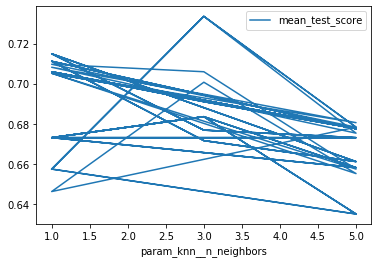

In [204]:
knn_metric_df = knn_df[knn_df['param_knn__p'] == 1]
knn_metric_df.plot(x='param_knn__n_neighbors', y='mean_test_score');

### Tuning Notes:

- **Hyperparameters**:        
    ```python
    knn_params = {
    "cvec__ngram_range": [(1, 1), (1, 2)],     # 2
    "cvec__max_features": [1000, 2500, 5000],  # 3
    "cvec__min_df": [1, 2, 5, 10],             # 4
    "knn__n_neighbors": [3, 5, 9, 11],         # 4
    "knn__p": [1, 2]                           # 2
    }
    ```
    - Score results:
        ```python
        Train Score: 0.9604477611940299
        Test Score: 0.7257575757575757
        Best Score: 0.7335820895522388
        ```
    - Best Parameters Returned:
        ```python
        {'cvec__max_features': 5000,
         'cvec__min_df': 1,
         'cvec__ngram_range': (1, 1),
         'knn__n_neighbors': 3,
         'knn__p': 1}
        ```
        - **Note:** The best distance was `Manhattan` distance
- **Next steps: increase cvec `max_features`, lower `n_neighbors`**

- **Hyperparameters**:        
    ```python
    knn_params = {
    "cvec__ngram_range": [(1, 1), (1, 2)],     # 2
    "cvec__max_features": [3000, 5000, 7500],  # 3
    "cvec__min_df": [1, 2, 5, 10],             # 4
    "knn__n_neighbors": [1, 3, 5],         # 4
    "knn__p": [1, 2]                           # 2
    }
    ```
    - Score results:
        ```python
        Train Score: 0.9559701492537314
        Test Score: 0.7439393939393939
        Best Score: 0.7335820895522388
        ```
    - Best Parameters Returned:
        ```python
        {'cvec__max_features': 3000,
         'cvec__min_df': 1,
         'cvec__ngram_range': (1, 1),
         'knn__n_neighbors': 3,
         'knn__p': 1}
        ```
        - **Note:** The best distance was `Manhattan` distance

### KNN Model Score Notes:

This model is overfit, but it seems like it's getting closer to a predicting the value of our target `y` variable.

Overall, we haven't reached especially high accuracy in our predictions.
 
 **Although the bias has increased (evident in how much worse it has become in prediction, even on the train data), it does seem to be getting closer to score equality with testing on data the model has not seen**

## KNN Regression w/ Tf idf

In [120]:
ss = StandardScaler(with_mean=False)  # Error message said to add this to the scalar

In [110]:
tfidf_knn_pipe = Pipeline([
    ("tfidf", TfidfVectorizer()), 
    ("ss", ss),
    ("tfidf_knn", KNeighborsClassifier())
])

**Looking at an untweaked model:**

In [111]:
# Testing the model performance on new data
print(f"CV Score Mean: {cross_val_score(tfidf_knn_pipe, X_train, y_train, cv=5).mean()}")

# Fit
tfidf_knn_pipe.fit(X_train, y_train)

# Train Score
print(f"Train Score: {tfidf_knn_pipe.score(X_train, y_train)}")

# Test Score
print(f"Test Score: {tfidf_knn_pipe.score(X_test, y_test)}")
tfidf_knn_default_score = tfidf_knn_pipe.score(X_test, y_test)

CV Score Mean: 0.5477611940298507
Train Score: 0.6611940298507463
Test Score: 0.5484848484848485


### Tuning:

In [112]:
tfidf_knn_params = {
    "tfidf__ngram_range": [(1, 1), (1, 2)],     
    "tfidf__max_features": [3000, 5000, 7500],  
    "tfidf__min_df": [1, 2, 5, 10],             
    "tfidf_knn__n_neighbors": [1, 3, 5],       
    "tfidf_knn__p": [1, 2]                     
}


tfidf_knn_gs = GridSearchCV(tfidf_knn_pipe,
                  tfidf_knn_params,
                  cv=5,
                  verbose=10)

In [113]:
tfidf_knn_gs.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=1 
[CV]  tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=1, score=0.631, total=   0.1s
[CV] tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=1, score=0.612, total=   0.1s
[CV] tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=1 
[CV]  tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=1, score=0.616, total=   0.1s
[CV] tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=1 
[CV]  tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=1, score=0.638, total=   0.1s
[CV] tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s


[CV]  tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=1, score=0.608, total=   0.2s
[CV] tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=2 
[CV]  tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=2, score=0.623, total=   0.1s
[CV] tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=2 
[CV]  tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=2, score=0.623, total=   0.1s
[CV] tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=2 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.9s remaining:    0.0s


[CV]  tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=2, score=0.638, total=   0.1s
[CV] tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=2 
[CV]  tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=2, score=0.653, total=   0.1s
[CV] tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=2 
[CV]  tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=2, score=0.649, total=   0.1s
[CV] tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=3, tfidf_knn__p=1 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.0s remaining:    0.0s


[CV]  tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=3, tfidf_knn__p=1, score=0.634, total=   0.1s
[CV] tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=3, tfidf_knn__p=1 
[CV]  tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=3, tfidf_knn__p=1, score=0.657, total=   0.1s
[CV] tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=3, tfidf_knn__p=1 
[CV]  tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=3, tfidf_knn__p=1, score=0.634, total=   0.1s
[CV] tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=3, tfidf_knn__p=1 
[CV]  tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=3, tfidf_knn__p=1, score=0.631, total=   0.1s
[CV] tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1

[CV]  tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=3, tfidf_knn__p=1, score=0.616, total=   0.2s
[CV] tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=3, tfidf_knn__p=1 
[CV]  tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=3, tfidf_knn__p=1, score=0.657, total=   0.2s
[CV] tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=3, tfidf_knn__p=2 
[CV]  tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=3, tfidf_knn__p=2, score=0.638, total=   0.2s
[CV] tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=3, tfidf_knn__p=2 
[CV]  tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=3, tfidf_knn__p=2, score=0.575, total=   0.3s
[CV] tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1

[CV]  tfidf__max_features=3000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=3, tfidf_knn__p=2, score=0.657, total=   0.1s
[CV] tfidf__max_features=3000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=3, tfidf_knn__p=2 
[CV]  tfidf__max_features=3000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=3, tfidf_knn__p=2, score=0.627, total=   0.3s
[CV] tfidf__max_features=3000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=3, tfidf_knn__p=2 
[CV]  tfidf__max_features=3000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=3, tfidf_knn__p=2, score=0.672, total=   0.1s
[CV] tfidf__max_features=3000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=3, tfidf_knn__p=2 
[CV]  tfidf__max_features=3000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=3, tfidf_knn__p=2, score=0.672, total=   0.1s
[CV] tfidf__max_features=3000, tfidf__min_df=2, tfidf__ngram_range=(1

[CV]  tfidf__max_features=3000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=3, tfidf_knn__p=2, score=0.642, total=   0.1s
[CV] tfidf__max_features=3000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=3, tfidf_knn__p=2 
[CV]  tfidf__max_features=3000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=3, tfidf_knn__p=2, score=0.679, total=   0.1s
[CV] tfidf__max_features=3000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=5, tfidf_knn__p=1 
[CV]  tfidf__max_features=3000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=5, tfidf_knn__p=1, score=0.586, total=   0.3s
[CV] tfidf__max_features=3000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=5, tfidf_knn__p=1 
[CV]  tfidf__max_features=3000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=5, tfidf_knn__p=1, score=0.545, total=   0.3s
[CV] tfidf__max_features=3000, tfidf__min_df=2, tfidf__ngram_range=(1

[CV]  tfidf__max_features=3000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=5, tfidf_knn__p=1, score=0.601, total=   0.1s
[CV] tfidf__max_features=3000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=5, tfidf_knn__p=1 
[CV]  tfidf__max_features=3000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=5, tfidf_knn__p=1, score=0.608, total=   0.1s
[CV] tfidf__max_features=3000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=5, tfidf_knn__p=1 
[CV]  tfidf__max_features=3000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=5, tfidf_knn__p=1, score=0.575, total=   0.1s
[CV] tfidf__max_features=3000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=5, tfidf_knn__p=1 
[CV]  tfidf__max_features=3000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=5, tfidf_knn__p=1, score=0.623, total=   0.1s
[CV] tfidf__max_features=3000, tfidf__min_df=5, tfidf__ngram_range=(1

[CV]  tfidf__max_features=3000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=5, tfidf_knn__p=1, score=0.567, total=   0.3s
[CV] tfidf__max_features=3000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=5, tfidf_knn__p=1 
[CV]  tfidf__max_features=3000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=5, tfidf_knn__p=1, score=0.575, total=   0.2s
[CV] tfidf__max_features=3000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=5, tfidf_knn__p=2 
[CV]  tfidf__max_features=3000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=5, tfidf_knn__p=2, score=0.616, total=   0.2s
[CV] tfidf__max_features=3000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=5, tfidf_knn__p=2 
[CV]  tfidf__max_features=3000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=5, tfidf_knn__p=2, score=0.683, total=   0.1s
[CV] tfidf__max_features=3000, tfidf__min_df=5, tfidf__ngram_range=(1

[CV]  tfidf__max_features=3000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=5, tfidf_knn__p=2, score=0.627, total=   0.2s
[CV] tfidf__max_features=3000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=5, tfidf_knn__p=2 
[CV]  tfidf__max_features=3000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=5, tfidf_knn__p=2, score=0.649, total=   0.2s
[CV] tfidf__max_features=3000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=5, tfidf_knn__p=2 
[CV]  tfidf__max_features=3000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=5, tfidf_knn__p=2, score=0.668, total=   0.1s
[CV] tfidf__max_features=3000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=5, tfidf_knn__p=2 
[CV]  tfidf__max_features=3000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=5, tfidf_knn__p=2, score=0.604, total=   0.1s
[CV] tfidf__max_features=3000, tfidf__min_df=10, tfidf__ngram_

[CV]  tfidf__max_features=3000, tfidf__min_df=10, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=5, tfidf_knn__p=2, score=0.619, total=   0.1s
[CV] tfidf__max_features=3000, tfidf__min_df=10, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=5, tfidf_knn__p=2 
[CV]  tfidf__max_features=3000, tfidf__min_df=10, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=5, tfidf_knn__p=2, score=0.649, total=   0.1s
[CV] tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=1 
[CV]  tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=1, score=0.631, total=   0.1s
[CV] tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=1 
[CV]  tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=1, score=0.612, total=   0.1s
[CV] tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range

[CV]  tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=1, tfidf_knn__p=1, score=0.627, total=   0.3s
[CV] tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=1, tfidf_knn__p=1 
[CV]  tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=1, tfidf_knn__p=1, score=0.634, total=   0.3s
[CV] tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=1, tfidf_knn__p=1 
[CV]  tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=1, tfidf_knn__p=1, score=0.638, total=   0.4s
[CV] tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=1, tfidf_knn__p=1 
[CV]  tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=1, tfidf_knn__p=1, score=0.627, total=   0.3s
[CV] tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1

[CV]  tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=1, score=0.642, total=   0.1s
[CV] tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=1 
[CV]  tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=1, score=0.679, total=   0.1s
[CV] tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=2 
[CV]  tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=2, score=0.653, total=   0.1s
[CV] tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=2 
[CV]  tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=2, score=0.679, total=   0.1s
[CV] tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1

[CV]  tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=1, tfidf_knn__p=2, score=0.646, total=   0.1s
[CV] tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=1, tfidf_knn__p=2 
[CV]  tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=1, tfidf_knn__p=2, score=0.683, total=   0.1s
[CV] tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=1, tfidf_knn__p=2 
[CV]  tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=1, tfidf_knn__p=2, score=0.668, total=   0.1s
[CV] tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=1, tfidf_knn__p=2 
[CV]  tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=1, tfidf_knn__p=2, score=0.646, total=   0.1s
[CV] tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1

[CV]  tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=2, score=0.675, total=   0.1s
[CV] tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=3, tfidf_knn__p=1 
[CV]  tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=3, tfidf_knn__p=1, score=0.597, total=   0.1s
[CV] tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=3, tfidf_knn__p=1 
[CV]  tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=3, tfidf_knn__p=1, score=0.627, total=   0.1s
[CV] tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=3, tfidf_knn__p=1 
[CV]  tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=3, tfidf_knn__p=1, score=0.608, total=   0.1s
[CV] tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1

[CV]  tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=3, tfidf_knn__p=1, score=0.616, total=   0.1s
[CV] tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=3, tfidf_knn__p=1 
[CV]  tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=3, tfidf_knn__p=1, score=0.604, total=   0.1s
[CV] tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=3, tfidf_knn__p=1 
[CV]  tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=3, tfidf_knn__p=1, score=0.646, total=   0.1s
[CV] tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=3, tfidf_knn__p=1 
[CV]  tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=3, tfidf_knn__p=1, score=0.608, total=   0.1s
[CV] tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1

[CV]  tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=3, tfidf_knn__p=1, score=0.623, total=   0.1s
[CV] tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=3, tfidf_knn__p=1 
[CV]  tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=3, tfidf_knn__p=1, score=0.631, total=   0.1s
[CV] tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=3, tfidf_knn__p=2 
[CV]  tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=3, tfidf_knn__p=2, score=0.634, total=   0.1s
[CV] tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=3, tfidf_knn__p=2 
[CV]  tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=3, tfidf_knn__p=2, score=0.664, total=   0.1s
[CV] tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_

[CV]  tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=3, tfidf_knn__p=2, score=0.649, total=   0.3s
[CV] tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=3, tfidf_knn__p=2 
[CV]  tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=3, tfidf_knn__p=2, score=0.672, total=   0.2s
[CV] tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=3, tfidf_knn__p=2 
[CV]  tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=3, tfidf_knn__p=2, score=0.649, total=   0.3s
[CV] tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=3, tfidf_knn__p=2 
[CV]  tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=3, tfidf_knn__p=2, score=0.608, total=   0.2s
[CV] tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_

[CV]  tfidf__max_features=7500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=3, tfidf_knn__p=2, score=0.687, total=   0.1s
[CV] tfidf__max_features=7500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=5, tfidf_knn__p=1 
[CV]  tfidf__max_features=7500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=5, tfidf_knn__p=1, score=0.537, total=   0.1s
[CV] tfidf__max_features=7500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=5, tfidf_knn__p=1 
[CV]  tfidf__max_features=7500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=5, tfidf_knn__p=1, score=0.556, total=   0.2s
[CV] tfidf__max_features=7500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=5, tfidf_knn__p=1 
[CV]  tfidf__max_features=7500, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=5, tfidf_knn__p=1, score=0.519, total=   0.2s
[CV] tfidf__max_features=7500, tfidf__min_df=1, tfidf__ngram_range=(1

[CV]  tfidf__max_features=7500, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=5, tfidf_knn__p=1, score=0.552, total=   0.2s
[CV] tfidf__max_features=7500, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=5, tfidf_knn__p=1 
[CV]  tfidf__max_features=7500, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=5, tfidf_knn__p=1, score=0.519, total=   0.2s
[CV] tfidf__max_features=7500, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=5, tfidf_knn__p=1 
[CV]  tfidf__max_features=7500, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=5, tfidf_knn__p=1, score=0.556, total=   0.1s
[CV] tfidf__max_features=7500, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=5, tfidf_knn__p=1 
[CV]  tfidf__max_features=7500, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=5, tfidf_knn__p=1, score=0.541, total=   0.1s
[CV] tfidf__max_features=7500, tfidf__min_df=1, tfidf__ngram_range=(1

[CV]  tfidf__max_features=7500, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=5, tfidf_knn__p=2, score=0.597, total=   0.1s
[CV] tfidf__max_features=7500, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=5, tfidf_knn__p=2 
[CV]  tfidf__max_features=7500, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=5, tfidf_knn__p=2, score=0.593, total=   0.1s
[CV] tfidf__max_features=7500, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=5, tfidf_knn__p=2 
[CV]  tfidf__max_features=7500, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=5, tfidf_knn__p=2, score=0.604, total=   0.1s
[CV] tfidf__max_features=7500, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=5, tfidf_knn__p=2 
[CV]  tfidf__max_features=7500, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=5, tfidf_knn__p=2, score=0.604, total=   0.1s
[CV] tfidf__max_features=7500, tfidf__min_df=2, tfidf__ngram_range=(1

[CV]  tfidf__max_features=7500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=5, tfidf_knn__p=2, score=0.530, total=   0.1s
[CV] tfidf__max_features=7500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=5, tfidf_knn__p=2 
[CV]  tfidf__max_features=7500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=5, tfidf_knn__p=2, score=0.590, total=   0.3s
[CV] tfidf__max_features=7500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=5, tfidf_knn__p=2 
[CV]  tfidf__max_features=7500, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=5, tfidf_knn__p=2, score=0.590, total=   0.2s
[CV] tfidf__max_features=7500, tfidf__min_df=5, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=1 
[CV]  tfidf__max_features=7500, tfidf__min_df=5, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=1, score=0.646, total=   0.1s
[CV] tfidf__max_features=7500, tfidf__min_df=5, tfidf__ngram_range=(1

[CV]  tfidf__max_features=7500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=1, tfidf_knn__p=1, score=0.713, total=   0.2s
[CV] tfidf__max_features=7500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=1, tfidf_knn__p=1 
[CV]  tfidf__max_features=7500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=1, tfidf_knn__p=1, score=0.709, total=   0.1s
[CV] tfidf__max_features=7500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=1, tfidf_knn__p=1 
[CV]  tfidf__max_features=7500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=1, tfidf_knn__p=1, score=0.705, total=   0.1s
[CV] tfidf__max_features=7500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=1, tfidf_knn__p=1 
[CV]  tfidf__max_features=7500, tfidf__min_df=5, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=1, tfidf_knn__p=1, score=0.701, total=   0.1s
[CV] tfidf__max_features=7500, tfidf__min_df=5, tfidf__ngram_range=(1

[CV]  tfidf__max_features=7500, tfidf__min_df=10, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=1, score=0.660, total=   0.1s
[CV] tfidf__max_features=7500, tfidf__min_df=10, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=1 
[CV]  tfidf__max_features=7500, tfidf__min_df=10, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=1, score=0.687, total=   0.1s
[CV] tfidf__max_features=7500, tfidf__min_df=10, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=2 
[CV]  tfidf__max_features=7500, tfidf__min_df=10, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=2, score=0.668, total=   0.1s
[CV] tfidf__max_features=7500, tfidf__min_df=10, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=2 
[CV]  tfidf__max_features=7500, tfidf__min_df=10, tfidf__ngram_range=(1, 1), tfidf_knn__n_neighbors=1, tfidf_knn__p=2, score=0.657, total=   0.1s
[CV] tfidf__max_features=7500, tfidf__min_df=10, tfidf__ngram_

[CV]  tfidf__max_features=7500, tfidf__min_df=10, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=1, tfidf_knn__p=2, score=0.657, total=   0.3s
[CV] tfidf__max_features=7500, tfidf__min_df=10, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=1, tfidf_knn__p=2 
[CV]  tfidf__max_features=7500, tfidf__min_df=10, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=1, tfidf_knn__p=2, score=0.687, total=   0.3s
[CV] tfidf__max_features=7500, tfidf__min_df=10, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=1, tfidf_knn__p=2 
[CV]  tfidf__max_features=7500, tfidf__min_df=10, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=1, tfidf_knn__p=2, score=0.638, total=   0.3s
[CV] tfidf__max_features=7500, tfidf__min_df=10, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=1, tfidf_knn__p=2 
[CV]  tfidf__max_features=7500, tfidf__min_df=10, tfidf__ngram_range=(1, 2), tfidf_knn__n_neighbors=1, tfidf_knn__p=2, score=0.660, total=   0.2s
[CV] tfidf__max_features=7500, tfidf__min_df=10, tfidf__ngram_

[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  1.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [117]:
print(f"Train Score: {tfidf_knn_gs.score(X_train, y_train)}")
print(f"Test Score: {tfidf_knn_gs.score(X_test, y_test)}\n")
print(f"Best Score: {tfidf_knn_gs.best_score_}")

Train Score: 0.9880597014925373
Test Score: 0.6893939393939394

Best Score: 0.7


In [118]:
best_params = tfidf_knn_gs.best_params_
best_params

{'tfidf__max_features': 3000,
 'tfidf__min_df': 5,
 'tfidf__ngram_range': (1, 2),
 'tfidf_knn__n_neighbors': 1,
 'tfidf_knn__p': 2}

In [119]:
tfidf_knn_df = pd.DataFrame(tfidf_knn_gs.cv_results_)
tfidf_knn_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tfidf__max_features,param_tfidf__min_df,param_tfidf__ngram_range,param_tfidf_knn__n_neighbors,param_tfidf_knn__p,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.069096,0.034767,0.061563,0.019000,3000,1,"(1, 1)",1,1,"{'tfidf__max_features': 3000, 'tfidf__min_df':...",0.630597,0.611940,0.615672,0.638060,0.608209,0.620896,0.011464,100
1,0.052100,0.019345,0.026091,0.004602,3000,1,"(1, 1)",1,2,"{'tfidf__max_features': 3000, 'tfidf__min_df':...",0.623134,0.623134,0.638060,0.652985,0.649254,0.637313,0.012576,77
2,0.043755,0.009582,0.040156,0.000932,3000,1,"(1, 1)",3,1,"{'tfidf__max_features': 3000, 'tfidf__min_df':...",0.634328,0.656716,0.634328,0.630597,0.649254,0.641045,0.010123,62
3,0.037914,0.008859,0.028559,0.008119,3000,1,"(1, 1)",3,2,"{'tfidf__max_features': 3000, 'tfidf__min_df':...",0.626866,0.675373,0.649254,0.634328,0.690299,0.655224,0.024136,35
4,0.043518,0.006971,0.050396,0.005883,3000,1,"(1, 1)",5,1,"{'tfidf__max_features': 3000, 'tfidf__min_df':...",0.522388,0.537313,0.533582,0.570896,0.514925,0.535821,0.019259,143


### Tuning Notes:

- **This absolutely needs to be parsed down to a smaller number of models to be fit. This `gs` is 12,960.**
- **Hyperparameters**:        
    ```python
    tfidf_logreg_params = {
    "tfidf__ngram_range": [(1, 1), (1, 2)],     
    "tfidf__max_features": [2500, 5000],  
    "tfidf__min_df": [1, 2, 5, 10],  
    "logreg__penalty": ["l1", "l2"],
    "logreg__C": [1, 5, 10],
    "logreg__random_state": [42],  # Needs a random_state when using the solvers below
    "logreg__solver": ["saga", "liblinear"],  # Will adjust to "lbfgs" if model prefers "l2" penalty
#     "logreg__max_iter": [100, 250, 500],  # This is being taken out, too many models
    "logreg__verbose": [1]  # Needs any positive int when using 'liblinear' solver
    }
    ```
    - Score results:
        ```python
    Train Score: 0.9880597014925373
    Test Score: 0.6893939393939394

    Best Score: 0.7
        ```
    - Best Parameters Returned:
        ```python
    {'tfidf__max_features': 3000,
     'tfidf__min_df': 5,
     'tfidf__ngram_range': (1, 2),
     'tfidf_knn__n_neighbors': 1,
     'tfidf_knn__p': 2}
        ```


- **Hyperparameters**:        
    ```python
    
    ```
    - Score results:
    ```python

    ```
    - Best Parameters Returned:
    ```python

    ```

### Logreg | CVEC Model Score Notes:


## Naive Bayes Model w/ CountVectorizer

In [154]:
nb_pipe = Pipeline([
    ("cvec", CountVectorizer()),
    ("nb", MultinomialNB())
])

**Looking at an untweaked model:**

In [212]:
# Testing the model performance on new data
print(f"CV Score Mean: {cross_val_score(nb_pipe, X_train, y_train, cv=5).mean()}")

# Fit
nb_pipe.fit(X_train, y_train)

# Train Score
print(f"Train Score: {nb_pipe.score(X_train, y_train)}")

# Test Score
print(f"Test Score: {nb_pipe.score(X_test, y_test)}")
nb_default_score = nb_pipe.score(X_test, y_test)

CV Score Mean: 0.7895522388059701
Train Score: 0.9529850746268657
Test Score: 0.793939393939394


### Tuning:

In [171]:
nb_params = {
    "cvec__ngram_range": [(1, 2), (1, 3), (1, 4)],
    "cvec__min_df": [1, 2],                  
    "cvec__max_features": [10_000, 12_500, 15_000],
    "nb__alpha": [1.0, 2.0, 3.0],
    "nb__fit_prior": [True, False]
}

nb_gs = GridSearchCV(nb_pipe,
                  nb_params,
                  cv=5,
                  verbose=10)

# 540 Models

In [172]:
nb_gs.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=True 
[CV]  cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=True, score=0.795, total=   0.1s
[CV] cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=True 
[CV]  cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=True, score=0.769, total=   0.1s
[CV] cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=True 
[CV]  cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=True, score=0.806, total=   0.1s
[CV] cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


[CV]  cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=True, score=0.791, total=   0.1s
[CV] cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=True 
[CV]  cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=True, score=0.821, total=   0.1s
[CV] cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=False 
[CV]  cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=False, score=0.787, total=   0.1s
[CV] cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=False 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s


[CV]  cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=False, score=0.772, total=   0.1s
[CV] cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=False 
[CV]  cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=False, score=0.810, total=   0.1s
[CV] cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=False 
[CV]  cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=False, score=0.780, total=   0.1s
[CV] cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=False 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.7s remaining:    0.0s


[CV]  cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=False, score=0.817, total=   0.1s
[CV] cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=2.0, nb__fit_prior=True 
[CV]  cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=2.0, nb__fit_prior=True, score=0.799, total=   0.1s
[CV] cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=2.0, nb__fit_prior=True 
[CV]  cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=2.0, nb__fit_prior=True, score=0.780, total=   0.1s
[CV] cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=2.0, nb__fit_prior=True 
[CV]  cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=2.0, nb__fit_prior=True, score=0.810, total=   0.1s
[CV] cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=2.0, nb__fit_prior=True 
[CV]  cvec__max_feature

[CV]  cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 3), nb__alpha=2.0, nb__fit_prior=True, score=0.769, total=   0.1s
[CV] cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 3), nb__alpha=2.0, nb__fit_prior=True 
[CV]  cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 3), nb__alpha=2.0, nb__fit_prior=True, score=0.802, total=   0.1s
[CV] cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 3), nb__alpha=2.0, nb__fit_prior=False 
[CV]  cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 3), nb__alpha=2.0, nb__fit_prior=False, score=0.784, total=   0.1s
[CV] cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 3), nb__alpha=2.0, nb__fit_prior=False 
[CV]  cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 3), nb__alpha=2.0, nb__fit_prior=False, score=0.750, total=   0.1s
[CV] cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 3), nb__alpha=2.0, nb__fit_prior=False 
[CV]  cvec__max_fea

[CV]  cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 4), nb__alpha=2.0, nb__fit_prior=False, score=0.784, total=   0.2s
[CV] cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 4), nb__alpha=2.0, nb__fit_prior=False 
[CV]  cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 4), nb__alpha=2.0, nb__fit_prior=False, score=0.757, total=   0.4s
[CV] cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 4), nb__alpha=2.0, nb__fit_prior=False 
[CV]  cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 4), nb__alpha=2.0, nb__fit_prior=False, score=0.784, total=   0.3s
[CV] cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 4), nb__alpha=3.0, nb__fit_prior=True 
[CV]  cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 4), nb__alpha=3.0, nb__fit_prior=True, score=0.787, total=   0.2s
[CV] cvec__max_features=10000, cvec__min_df=1, cvec__ngram_range=(1, 4), nb__alpha=3.0, nb__fit_prior=True 
[CV]  cvec__max_fea

[CV]  cvec__max_features=10000, cvec__min_df=2, cvec__ngram_range=(1, 2), nb__alpha=3.0, nb__fit_prior=True, score=0.739, total=   0.0s
[CV] cvec__max_features=10000, cvec__min_df=2, cvec__ngram_range=(1, 2), nb__alpha=3.0, nb__fit_prior=True 
[CV]  cvec__max_features=10000, cvec__min_df=2, cvec__ngram_range=(1, 2), nb__alpha=3.0, nb__fit_prior=True, score=0.765, total=   0.1s
[CV] cvec__max_features=10000, cvec__min_df=2, cvec__ngram_range=(1, 2), nb__alpha=3.0, nb__fit_prior=True 
[CV]  cvec__max_features=10000, cvec__min_df=2, cvec__ngram_range=(1, 2), nb__alpha=3.0, nb__fit_prior=True, score=0.761, total=   0.1s
[CV] cvec__max_features=10000, cvec__min_df=2, cvec__ngram_range=(1, 2), nb__alpha=3.0, nb__fit_prior=True 
[CV]  cvec__max_features=10000, cvec__min_df=2, cvec__ngram_range=(1, 2), nb__alpha=3.0, nb__fit_prior=True, score=0.761, total=   0.0s
[CV] cvec__max_features=10000, cvec__min_df=2, cvec__ngram_range=(1, 2), nb__alpha=3.0, nb__fit_prior=False 
[CV]  cvec__max_feature

[CV]  cvec__max_features=10000, cvec__min_df=2, cvec__ngram_range=(1, 3), nb__alpha=3.0, nb__fit_prior=False, score=0.765, total=   0.1s
[CV] cvec__max_features=10000, cvec__min_df=2, cvec__ngram_range=(1, 3), nb__alpha=3.0, nb__fit_prior=False 
[CV]  cvec__max_features=10000, cvec__min_df=2, cvec__ngram_range=(1, 3), nb__alpha=3.0, nb__fit_prior=False, score=0.731, total=   0.1s
[CV] cvec__max_features=10000, cvec__min_df=2, cvec__ngram_range=(1, 3), nb__alpha=3.0, nb__fit_prior=False 
[CV]  cvec__max_features=10000, cvec__min_df=2, cvec__ngram_range=(1, 3), nb__alpha=3.0, nb__fit_prior=False, score=0.765, total=   0.1s
[CV] cvec__max_features=10000, cvec__min_df=2, cvec__ngram_range=(1, 3), nb__alpha=3.0, nb__fit_prior=False 
[CV]  cvec__max_features=10000, cvec__min_df=2, cvec__ngram_range=(1, 3), nb__alpha=3.0, nb__fit_prior=False, score=0.757, total=   0.1s
[CV] cvec__max_features=10000, cvec__min_df=2, cvec__ngram_range=(1, 3), nb__alpha=3.0, nb__fit_prior=False 
[CV]  cvec__max_

[CV] cvec__max_features=10000, cvec__min_df=2, cvec__ngram_range=(1, 4), nb__alpha=3.0, nb__fit_prior=False 
[CV]  cvec__max_features=10000, cvec__min_df=2, cvec__ngram_range=(1, 4), nb__alpha=3.0, nb__fit_prior=False, score=0.750, total=   0.1s
[CV] cvec__max_features=12500, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=True 
[CV]  cvec__max_features=12500, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=True, score=0.799, total=   0.0s
[CV] cvec__max_features=12500, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=True 
[CV]  cvec__max_features=12500, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=True, score=0.761, total=   0.0s
[CV] cvec__max_features=12500, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=True 
[CV]  cvec__max_features=12500, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=True, score=0.821, total=   0.1s
[CV] cvec__max_feature

[CV]  cvec__max_features=12500, cvec__min_df=1, cvec__ngram_range=(1, 3), nb__alpha=1.0, nb__fit_prior=True, score=0.780, total=   0.1s
[CV] cvec__max_features=12500, cvec__min_df=1, cvec__ngram_range=(1, 3), nb__alpha=1.0, nb__fit_prior=True 
[CV]  cvec__max_features=12500, cvec__min_df=1, cvec__ngram_range=(1, 3), nb__alpha=1.0, nb__fit_prior=True, score=0.813, total=   0.1s
[CV] cvec__max_features=12500, cvec__min_df=1, cvec__ngram_range=(1, 3), nb__alpha=1.0, nb__fit_prior=False 
[CV]  cvec__max_features=12500, cvec__min_df=1, cvec__ngram_range=(1, 3), nb__alpha=1.0, nb__fit_prior=False, score=0.784, total=   0.1s
[CV] cvec__max_features=12500, cvec__min_df=1, cvec__ngram_range=(1, 3), nb__alpha=1.0, nb__fit_prior=False 
[CV]  cvec__max_features=12500, cvec__min_df=1, cvec__ngram_range=(1, 3), nb__alpha=1.0, nb__fit_prior=False, score=0.769, total=   0.1s
[CV] cvec__max_features=12500, cvec__min_df=1, cvec__ngram_range=(1, 3), nb__alpha=1.0, nb__fit_prior=False 
[CV]  cvec__max_fea

[CV]  cvec__max_features=12500, cvec__min_df=1, cvec__ngram_range=(1, 4), nb__alpha=1.0, nb__fit_prior=False, score=0.765, total=   0.1s
[CV] cvec__max_features=12500, cvec__min_df=1, cvec__ngram_range=(1, 4), nb__alpha=1.0, nb__fit_prior=False 
[CV]  cvec__max_features=12500, cvec__min_df=1, cvec__ngram_range=(1, 4), nb__alpha=1.0, nb__fit_prior=False, score=0.802, total=   0.1s
[CV] cvec__max_features=12500, cvec__min_df=1, cvec__ngram_range=(1, 4), nb__alpha=2.0, nb__fit_prior=True 
[CV]  cvec__max_features=12500, cvec__min_df=1, cvec__ngram_range=(1, 4), nb__alpha=2.0, nb__fit_prior=True, score=0.795, total=   0.1s
[CV] cvec__max_features=12500, cvec__min_df=1, cvec__ngram_range=(1, 4), nb__alpha=2.0, nb__fit_prior=True 
[CV]  cvec__max_features=12500, cvec__min_df=1, cvec__ngram_range=(1, 4), nb__alpha=2.0, nb__fit_prior=True, score=0.757, total=   0.1s
[CV] cvec__max_features=12500, cvec__min_df=1, cvec__ngram_range=(1, 4), nb__alpha=2.0, nb__fit_prior=True 
[CV]  cvec__max_featu

[CV]  cvec__max_features=12500, cvec__min_df=2, cvec__ngram_range=(1, 2), nb__alpha=2.0, nb__fit_prior=True, score=0.776, total=   0.1s
[CV] cvec__max_features=12500, cvec__min_df=2, cvec__ngram_range=(1, 2), nb__alpha=2.0, nb__fit_prior=True 
[CV]  cvec__max_features=12500, cvec__min_df=2, cvec__ngram_range=(1, 2), nb__alpha=2.0, nb__fit_prior=True, score=0.761, total=   0.1s
[CV] cvec__max_features=12500, cvec__min_df=2, cvec__ngram_range=(1, 2), nb__alpha=2.0, nb__fit_prior=True 
[CV]  cvec__max_features=12500, cvec__min_df=2, cvec__ngram_range=(1, 2), nb__alpha=2.0, nb__fit_prior=True, score=0.769, total=   0.1s
[CV] cvec__max_features=12500, cvec__min_df=2, cvec__ngram_range=(1, 2), nb__alpha=2.0, nb__fit_prior=False 
[CV]  cvec__max_features=12500, cvec__min_df=2, cvec__ngram_range=(1, 2), nb__alpha=2.0, nb__fit_prior=False, score=0.765, total=   0.1s
[CV] cvec__max_features=12500, cvec__min_df=2, cvec__ngram_range=(1, 2), nb__alpha=2.0, nb__fit_prior=False 
[CV]  cvec__max_featu

[CV]  cvec__max_features=12500, cvec__min_df=2, cvec__ngram_range=(1, 3), nb__alpha=2.0, nb__fit_prior=False, score=0.780, total=   0.1s
[CV] cvec__max_features=12500, cvec__min_df=2, cvec__ngram_range=(1, 3), nb__alpha=2.0, nb__fit_prior=False 
[CV]  cvec__max_features=12500, cvec__min_df=2, cvec__ngram_range=(1, 3), nb__alpha=2.0, nb__fit_prior=False, score=0.754, total=   0.1s
[CV] cvec__max_features=12500, cvec__min_df=2, cvec__ngram_range=(1, 3), nb__alpha=2.0, nb__fit_prior=False 
[CV]  cvec__max_features=12500, cvec__min_df=2, cvec__ngram_range=(1, 3), nb__alpha=2.0, nb__fit_prior=False, score=0.757, total=   0.1s
[CV] cvec__max_features=12500, cvec__min_df=2, cvec__ngram_range=(1, 3), nb__alpha=3.0, nb__fit_prior=True 
[CV]  cvec__max_features=12500, cvec__min_df=2, cvec__ngram_range=(1, 3), nb__alpha=3.0, nb__fit_prior=True, score=0.780, total=   0.1s
[CV] cvec__max_features=12500, cvec__min_df=2, cvec__ngram_range=(1, 3), nb__alpha=3.0, nb__fit_prior=True 
[CV]  cvec__max_fea

[CV]  cvec__max_features=12500, cvec__min_df=2, cvec__ngram_range=(1, 4), nb__alpha=3.0, nb__fit_prior=True, score=0.739, total=   0.1s
[CV] cvec__max_features=12500, cvec__min_df=2, cvec__ngram_range=(1, 4), nb__alpha=3.0, nb__fit_prior=True 
[CV]  cvec__max_features=12500, cvec__min_df=2, cvec__ngram_range=(1, 4), nb__alpha=3.0, nb__fit_prior=True, score=0.765, total=   0.1s
[CV] cvec__max_features=12500, cvec__min_df=2, cvec__ngram_range=(1, 4), nb__alpha=3.0, nb__fit_prior=True 
[CV]  cvec__max_features=12500, cvec__min_df=2, cvec__ngram_range=(1, 4), nb__alpha=3.0, nb__fit_prior=True, score=0.765, total=   0.1s
[CV] cvec__max_features=12500, cvec__min_df=2, cvec__ngram_range=(1, 4), nb__alpha=3.0, nb__fit_prior=True 
[CV]  cvec__max_features=12500, cvec__min_df=2, cvec__ngram_range=(1, 4), nb__alpha=3.0, nb__fit_prior=True, score=0.757, total=   0.1s
[CV] cvec__max_features=12500, cvec__min_df=2, cvec__ngram_range=(1, 4), nb__alpha=3.0, nb__fit_prior=False 
[CV]  cvec__max_feature

[CV]  cvec__max_features=15000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=3.0, nb__fit_prior=False, score=0.791, total=   0.1s
[CV] cvec__max_features=15000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=3.0, nb__fit_prior=False 
[CV]  cvec__max_features=15000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=3.0, nb__fit_prior=False, score=0.772, total=   0.1s
[CV] cvec__max_features=15000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=3.0, nb__fit_prior=False 
[CV]  cvec__max_features=15000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=3.0, nb__fit_prior=False, score=0.802, total=   0.1s
[CV] cvec__max_features=15000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=3.0, nb__fit_prior=False 
[CV]  cvec__max_features=15000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=3.0, nb__fit_prior=False, score=0.784, total=   0.1s
[CV] cvec__max_features=15000, cvec__min_df=1, cvec__ngram_range=(1, 2), nb__alpha=3.0, nb__fit_prior=False 
[CV]  cvec__max_

[CV]  cvec__max_features=15000, cvec__min_df=1, cvec__ngram_range=(1, 3), nb__alpha=3.0, nb__fit_prior=False, score=0.802, total=   0.1s
[CV] cvec__max_features=15000, cvec__min_df=1, cvec__ngram_range=(1, 4), nb__alpha=1.0, nb__fit_prior=True 
[CV]  cvec__max_features=15000, cvec__min_df=1, cvec__ngram_range=(1, 4), nb__alpha=1.0, nb__fit_prior=True, score=0.787, total=   0.1s
[CV] cvec__max_features=15000, cvec__min_df=1, cvec__ngram_range=(1, 4), nb__alpha=1.0, nb__fit_prior=True 
[CV]  cvec__max_features=15000, cvec__min_df=1, cvec__ngram_range=(1, 4), nb__alpha=1.0, nb__fit_prior=True, score=0.780, total=   0.1s
[CV] cvec__max_features=15000, cvec__min_df=1, cvec__ngram_range=(1, 4), nb__alpha=1.0, nb__fit_prior=True 
[CV]  cvec__max_features=15000, cvec__min_df=1, cvec__ngram_range=(1, 4), nb__alpha=1.0, nb__fit_prior=True, score=0.787, total=   0.1s
[CV] cvec__max_features=15000, cvec__min_df=1, cvec__ngram_range=(1, 4), nb__alpha=1.0, nb__fit_prior=True 
[CV]  cvec__max_feature

[CV]  cvec__max_features=15000, cvec__min_df=2, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=True, score=0.780, total=   0.1s
[CV] cvec__max_features=15000, cvec__min_df=2, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=False 
[CV]  cvec__max_features=15000, cvec__min_df=2, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=False, score=0.754, total=   0.1s
[CV] cvec__max_features=15000, cvec__min_df=2, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=False 
[CV]  cvec__max_features=15000, cvec__min_df=2, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=False, score=0.746, total=   0.1s
[CV] cvec__max_features=15000, cvec__min_df=2, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=False 
[CV]  cvec__max_features=15000, cvec__min_df=2, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=False, score=0.784, total=   0.1s
[CV] cvec__max_features=15000, cvec__min_df=2, cvec__ngram_range=(1, 2), nb__alpha=1.0, nb__fit_prior=False 
[CV]  cvec__max_f

[CV]  cvec__max_features=15000, cvec__min_df=2, cvec__ngram_range=(1, 3), nb__alpha=2.0, nb__fit_prior=True, score=0.769, total=   0.1s
[CV] cvec__max_features=15000, cvec__min_df=2, cvec__ngram_range=(1, 3), nb__alpha=2.0, nb__fit_prior=True 
[CV]  cvec__max_features=15000, cvec__min_df=2, cvec__ngram_range=(1, 3), nb__alpha=2.0, nb__fit_prior=True, score=0.743, total=   0.1s
[CV] cvec__max_features=15000, cvec__min_df=2, cvec__ngram_range=(1, 3), nb__alpha=2.0, nb__fit_prior=True 
[CV]  cvec__max_features=15000, cvec__min_df=2, cvec__ngram_range=(1, 3), nb__alpha=2.0, nb__fit_prior=True, score=0.776, total=   0.1s
[CV] cvec__max_features=15000, cvec__min_df=2, cvec__ngram_range=(1, 3), nb__alpha=2.0, nb__fit_prior=True 
[CV]  cvec__max_features=15000, cvec__min_df=2, cvec__ngram_range=(1, 3), nb__alpha=2.0, nb__fit_prior=True, score=0.765, total=   0.1s
[CV] cvec__max_features=15000, cvec__min_df=2, cvec__ngram_range=(1, 3), nb__alpha=2.0, nb__fit_prior=True 
[CV]  cvec__max_features

[CV]  cvec__max_features=15000, cvec__min_df=2, cvec__ngram_range=(1, 4), nb__alpha=2.0, nb__fit_prior=True, score=0.757, total=   0.1s
[CV] cvec__max_features=15000, cvec__min_df=2, cvec__ngram_range=(1, 4), nb__alpha=2.0, nb__fit_prior=False 
[CV]  cvec__max_features=15000, cvec__min_df=2, cvec__ngram_range=(1, 4), nb__alpha=2.0, nb__fit_prior=False, score=0.765, total=   0.1s
[CV] cvec__max_features=15000, cvec__min_df=2, cvec__ngram_range=(1, 4), nb__alpha=2.0, nb__fit_prior=False 
[CV]  cvec__max_features=15000, cvec__min_df=2, cvec__ngram_range=(1, 4), nb__alpha=2.0, nb__fit_prior=False, score=0.739, total=   0.1s
[CV] cvec__max_features=15000, cvec__min_df=2, cvec__ngram_range=(1, 4), nb__alpha=2.0, nb__fit_prior=False 
[CV]  cvec__max_features=15000, cvec__min_df=2, cvec__ngram_range=(1, 4), nb__alpha=2.0, nb__fit_prior=False, score=0.772, total=   0.1s
[CV] cvec__max_features=15000, cvec__min_df=2, cvec__ngram_range=(1, 4), nb__alpha=2.0, nb__fit_prior=False 
[CV]  cvec__max_f

[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:   51.8s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [173]:
print(f"Train Score: {nb_gs.score(X_train, y_train)}")
print(f"Test Score: {nb_gs.score(X_test, y_test)}")
print(f"Best Score: {nb_gs.best_score_}")

Train Score: 0.9798507462686568
Test Score: 0.7954545454545454
Best Score: 0.8044776119402985


In [174]:
best_params = nb_gs.best_params_
best_params

{'cvec__max_features': 12500,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 2),
 'nb__alpha': 2.0,
 'nb__fit_prior': True}

In [175]:
nb_df = pd.DataFrame(nb_gs.cv_results_)
nb_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,param_nb__alpha,param_nb__fit_prior,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.063562,0.015828,0.008391,0.002368,10000,1,"(1, 2)",1,True,"{'cvec__max_features': 10000, 'cvec__min_df': ...",0.794776,0.768657,0.805970,0.791045,0.820896,0.796269,0.017277,8
1,0.068338,0.014057,0.007392,0.000725,10000,1,"(1, 2)",1,False,"{'cvec__max_features': 10000, 'cvec__min_df': ...",0.787313,0.772388,0.809701,0.779851,0.817164,0.793284,0.017277,16
2,0.056435,0.013816,0.006894,0.000489,10000,1,"(1, 2)",2,True,"{'cvec__max_features': 10000, 'cvec__min_df': ...",0.798507,0.779851,0.809701,0.787313,0.813433,0.797761,0.012796,7
3,0.058836,0.013312,0.007427,0.000983,10000,1,"(1, 2)",2,False,"{'cvec__max_features': 10000, 'cvec__min_df': ...",0.794776,0.783582,0.813433,0.776119,0.809701,0.795522,0.014432,12
4,0.054567,0.008376,0.006833,0.000933,10000,1,"(1, 2)",3,True,"{'cvec__max_features': 10000, 'cvec__min_df': ...",0.791045,0.764925,0.794776,0.791045,0.809701,0.790299,0.014432,22


### Tuning Notes:

- **Hyperparameters**:        
    ```python
    nb_params = {
    "cvec__ngram_range": [(1, 1), (1, 2), (1, 3)],
    "cvec__min_df": [1, 2, 5, 10],                  
    "cvec__max_features": [2500, 5000, 10_000],
    "nb__alpha": [0, 1.0, 2.0, 3.0],
    "nb__fit_prior": [True, False]
    ```
    - Score results:
        ```python
        Train Score: 0.9738805970149254
        Test Score: 0.7984848484848485
        Best Score: 0.7977611940298507
        ```
    - Best Parameters Returned:
        ```python
        {'cvec__max_features': 10000,
         'cvec__min_df': 1,
         'cvec__ngram_range': (1, 2),
         'nb__alpha': 2.0,
         'nb__fit_prior': True}
        ```
    - **Notes:** These scores are less overfit. Not super accurate as a whole, but a huge improvement over KNN. The model is much more accurate on test data
- **Next steps:** Increase the `max_features`, and increase `ngram_range`

- **Hyperparameters**:        
    ```python
    "cvec__ngram_range": [(1, 2), (1, 3), (1, 4)],
    "cvec__min_df": [1, 2],                  
    "cvec__max_features": [10_000, 12_500, 15_000],
    "nb__alpha": [1.0, 2.0, 3.0],
    "nb__fit_prior": [True, False]
    ```
    - Score results:
        ```python
        Train Score: 0.9798507462686568
        Test Score: 0.7954545454545454
        Best Score: 0.8044776119402985
        ```
    - Best Parameters Returned:
        ```python
        {'cvec__max_features': 12500,
         'cvec__min_df': 1,
         'cvec__ngram_range': (1, 2),
         'nb__alpha': 2.0,
         'nb__fit_prior': True}
        ```
- **Notes:** Has a better `best_score_`, and the best score so far.

### Naive Bayes Multinomial Model Score Notes:
